In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import pandas as pd
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from keras.callbacks import EarlyStopping 
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 100, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

## 다변량 RNN LSTM, 과거 한시점으로 현재 한시점 예측

In [3]:
df_apart=pd.read_csv('./data/data_2.csv')

In [4]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [5]:
# df_apart=df_apart.iloc[:,1:]
df_apart['date']=pd.to_datetime(df_apart['date'])
df_time = df_apart['date']
df_time.to_frame()
df_apart = df_apart.set_index('date')

In [6]:
df_apart

,kosave,kosave_quant,kosave_amt,bc,ar,unsoldapt,tr_bond,loan_apt,cd,houseloan_county,...,termdepo,interrate_call,interrate_kb,cpi_jeon,cpi_total,ppi_realestate,ppi_buildlease,cci,cli,SPI
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1986.10,495654538,4434353297,144956.7,1567.9,3415,2.75,440.43,2.86,200072.2,...,883814.7,2.76,2.75,91.412,93.090,96.46,98.10,93.3,89.1,74.48
2013-02-01,1979.85,384608603,3674863781,146954.1,1558.3,3308,2.70,839.76,2.83,199441.8,...,883161.2,2.75,2.75,91.658,93.318,98.19,98.22,93.6,89.4,74.78
2013-03-01,1990.24,342831485,3830684225,149050.3,1435.2,3168,2.60,940.27,2.81,199090.2,...,881062.7,2.74,2.75,91.986,93.613,98.22,98.29,94.3,89.7,75.42
2013-04-01,1938.88,349743992,4358558297,155254.8,1408.7,3035,2.55,1745.47,2.80,199239.5,...,877119.5,2.75,2.75,92.315,93.891,98.05,98.16,95.0,90.1,75.64
2013-05-01,1974.45,313666214,4220941937,160391.1,1382.2,2908,2.59,1869.58,2.72,200043.2,...,874704.4,2.55,2.50,92.561,94.102,98.57,98.22,95.3,90.4,75.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,1944.24,498673,4662803,216662.0,299.6,205,1.16,14792.41,1.49,314138.1,...,1176732.9,1.51,1.50,110.450,106.040,108.50,103.09,112.6,115.7,122.84
2019-09-01,2045.21,453725,4520648,222503.4,293.8,207,1.29,17763.43,1.54,315819.7,...,1186785.6,1.52,1.50,110.490,106.060,108.37,103.24,112.5,116.1,124.18
2019-10-01,2065.75,423066,4421096,222908.9,288.0,191,1.36,35599.44,1.46,318900.5,...,1201916.8,1.36,1.25,110.560,106.140,108.76,103.28,112.2,116.8,126.02


## train, valid, test 셋 split

In [7]:
train = df_apart.iloc[:41,:]
valid = df_apart.iloc[41:59,:]
test = df_apart.iloc[59:,:]

In [8]:
print(train.head())
print(valid.head())
print(test.head())

             kosave  kosave_quant  kosave_amt        bc      ar  unsoldapt  \
date                                                                         
2013-01-01  1986.10     495654538  4434353297  144956.7  1567.9       3415   
2013-02-01  1979.85     384608603  3674863781  146954.1  1558.3       3308   
2013-03-01  1990.24     342831485  3830684225  149050.3  1435.2       3168   
2013-04-01  1938.88     349743992  4358558297  155254.8  1408.7       3035   
2013-05-01  1974.45     313666214  4220941937  160391.1  1382.2       2908   

            tr_bond  loan_apt    cd  houseloan_county  ...  termdepo  \
date                                                   ...             
2013-01-01     2.75    440.43  2.86          200072.2  ...  883814.7   
2013-02-01     2.70    839.76  2.83          199441.8  ...  883161.2   
2013-03-01     2.60    940.27  2.81          199090.2  ...  881062.7   
2013-04-01     2.55   1745.47  2.80          199239.5  ...  877119.5   
2013-05-01     2.59  

### Data Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler
# 스케일러 생성
sc = MinMaxScaler()
# train, valid, test 각각 스케일링 
#같이 fit될 경우 추후 모델 학습시에 낙관적으로 나올 수 있으므로
train_sc = sc.fit_transform(train)
valid_sc = sc.transform(valid)
test_sc = sc.transform(test)
#배열로 변환되었으므로 다시 데이터 프레임으로 변환(병합 위해)
train_sc = pd.DataFrame(data = train_sc, columns = train.columns)
valid_sc = pd.DataFrame(data = valid_sc, columns = valid.columns)
test_sc = pd.DataFrame(data = test_sc, columns = test.columns)

In [10]:
#세 데이터셋 pd.concat()으로 병합
scaledf =pd.concat([train_sc,valid_sc,test_sc])

In [11]:
#스케일된 데이터셋을 배열로 변환
scaled = scaledf.values 

In [12]:
# 차원 및 크기 출력
scaled.shape

(84, 23)

In [13]:
# 각 변수 당 t-1과 t시점의 time step을 만들어주는 함수 생성
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [14]:
reframed = series_to_supervised(scaled, 1, 1)
#t-1시점,t시점 데이터를 한 행으로 둔다    

In [15]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t)
1,0.470242,1.000000,0.953268,0.000000,1.000000,0.776039,0.871033,0.027437,1.000000,0.020955,...,0.396861,0.992188,1.0,0.020781,0.025193,0.311151,0.047809,0.037975,0.021277,0.024390
2,0.444536,0.775814,0.789852,0.057833,0.989603,0.749878,0.837272,0.071112,0.976563,0.007503,...,0.350418,0.984375,1.0,0.048488,0.057790,0.316547,0.075697,0.126582,0.042553,0.076423
3,0.487270,0.691471,0.823379,0.118526,0.856276,0.715648,0.769750,0.082105,0.960938,0.000000,...,0.263148,0.992188,1.0,0.076280,0.088508,0.285971,0.023904,0.215190,0.070922,0.094309
4,0.276025,0.705427,0.936959,0.298171,0.827575,0.683130,0.735989,0.170171,0.953125,0.003186,...,0.209698,0.835938,0.8,0.097060,0.111823,0.379496,0.047809,0.253165,0.092199,0.101626
5,0.422326,0.632591,0.907349,0.446887,0.798874,0.652078,0.762998,0.183745,0.890625,0.020337,...,0.122399,0.789063,0.8,0.117841,0.132376,0.329137,0.095618,0.291139,0.127660,0.071545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.854317,0.000387,0.000101,2.117266,-0.359255,-0.012469,-0.054018,1.278029,0.078125,2.380592,...,6.894095,0.023438,0.0,1.608211,1.430939,2.165468,1.988048,2.443038,1.886525,3.931707
80,0.298071,0.000349,0.000152,2.076152,-0.373660,-0.008802,-0.202566,1.597129,-0.070312,2.455062,...,7.116579,0.031250,0.0,1.611590,1.433149,2.142086,2.047809,2.430380,1.914894,4.040650
81,0.713363,0.000258,0.000121,2.245283,-0.379942,-0.008313,-0.114787,1.922073,-0.031250,2.490947,...,7.451457,-0.093750,-0.2,1.617503,1.441989,2.212230,2.063745,2.392405,1.964539,4.190244
82,0.797845,0.000196,0.000100,2.257024,-0.386223,-0.012225,-0.067522,3.872818,-0.093750,2.556689,...,7.716042,-0.156250,-0.2,1.622571,1.448619,2.205036,2.059761,2.392405,2.014184,4.379675


In [16]:
reframed.shape

(83, 46)

In [17]:
# 윈도우가 만들어진 데이터 프레임을 또다서 세 데이터셋으로 split
train = reframed.iloc[:40,:]
valid = reframed.iloc[40:58,:]
test = reframed.iloc[58:,:]
#배열로 변환
train_values = train.values
valid_values = valid.values
test_values = test.values

In [18]:
#X와 y(t시점의 종속변수(SPI) 나누기
train_X, train_y = train_values[:, :-1], train_values[:, -1]
valid_X, valid_y = valid_values[:, :-1], valid_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]

In [19]:
#LSTM 모델 학습 시 input값이 3차원 배열이 들어가야하므로 3차원 배열로 변환
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_y = train_y.reshape((train_y.shape[0], 1))

valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
valid_y = valid_y.reshape((valid_y.shape[0], 1))

test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_y = test_y.reshape((test_y.shape[0], 1))


In [20]:
#각 배열의 차원 및 크기 출력
print(train_X.shape,valid_X.shape,test_X.shape)
print(train_y.shape,valid_y.shape,test_y.shape)

(40, 1, 45) (18, 1, 45) (25, 1, 45)
(40, 1) (18, 1) (25, 1)


### 모델빌드 (다변량 LSTM (t-1시점으로 t시점 예측))

In [21]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

np.random.seed(120)
tf.random.set_seed(120)

model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='sgd',metrics=['mse','mae'])
# 모델을 훈련시킨 후
history = model.fit(train_X, train_y, epochs=1000, batch_size=40, 
        validation_data=(valid_X, valid_y), verbose=2,callbacks=[early_stop])


#최종선택
#Batch = 64
#Encoder = 256
#Decoder = 256
#Epochs = 1000


Epoch 1/1000
1/1 - 0s - loss: 0.4921 - mse: 0.4921 - mae: 0.5772 - val_loss: 3.4037 - val_mse: 3.4037 - val_mae: 1.8156
Epoch 2/1000
1/1 - 0s - loss: 0.4604 - mse: 0.4604 - mae: 0.5520 - val_loss: 3.2677 - val_mse: 3.2677 - val_mae: 1.7783
Epoch 3/1000
1/1 - 0s - loss: 0.4312 - mse: 0.4312 - mae: 0.5279 - val_loss: 3.1385 - val_mse: 3.1385 - val_mae: 1.7422
Epoch 4/1000
1/1 - 0s - loss: 0.4042 - mse: 0.4042 - mae: 0.5052 - val_loss: 3.0159 - val_mse: 3.0159 - val_mae: 1.7072
Epoch 5/1000
1/1 - 0s - loss: 0.3793 - mse: 0.3793 - mae: 0.4840 - val_loss: 2.8993 - val_mse: 2.8993 - val_mae: 1.6733
Epoch 6/1000
1/1 - 0s - loss: 0.3564 - mse: 0.3564 - mae: 0.4636 - val_loss: 2.7885 - val_mse: 2.7885 - val_mae: 1.6405
Epoch 7/1000
1/1 - 0s - loss: 0.3352 - mse: 0.3352 - mae: 0.4440 - val_loss: 2.6832 - val_mse: 2.6832 - val_mae: 1.6086
Epoch 8/1000
1/1 - 0s - loss: 0.3156 - mse: 0.3156 - mae: 0.4259 - val_loss: 2.5831 - val_mse: 2.5831 - val_mae: 1.5778
Epoch 9/1000
1/1 - 0s - loss: 0.2975 - m

Epoch 69/1000
1/1 - 0s - loss: 0.0462 - mse: 0.0462 - mae: 0.1908 - val_loss: 0.6182 - val_mse: 0.6182 - val_mae: 0.7529
Epoch 70/1000
1/1 - 0s - loss: 0.0454 - mse: 0.0454 - mae: 0.1894 - val_loss: 0.6101 - val_mse: 0.6101 - val_mae: 0.7476
Epoch 71/1000
1/1 - 0s - loss: 0.0446 - mse: 0.0446 - mae: 0.1879 - val_loss: 0.6023 - val_mse: 0.6023 - val_mae: 0.7424
Epoch 72/1000
1/1 - 0s - loss: 0.0438 - mse: 0.0438 - mae: 0.1865 - val_loss: 0.5946 - val_mse: 0.5946 - val_mae: 0.7374
Epoch 73/1000
1/1 - 0s - loss: 0.0430 - mse: 0.0430 - mae: 0.1851 - val_loss: 0.5872 - val_mse: 0.5872 - val_mae: 0.7324
Epoch 74/1000
1/1 - 0s - loss: 0.0423 - mse: 0.0423 - mae: 0.1837 - val_loss: 0.5799 - val_mse: 0.5799 - val_mae: 0.7275
Epoch 75/1000
1/1 - 0s - loss: 0.0416 - mse: 0.0416 - mae: 0.1822 - val_loss: 0.5728 - val_mse: 0.5728 - val_mae: 0.7228
Epoch 76/1000
1/1 - 0s - loss: 0.0409 - mse: 0.0409 - mae: 0.1808 - val_loss: 0.5659 - val_mse: 0.5659 - val_mae: 0.7181
Epoch 77/1000
1/1 - 0s - loss: 0

Epoch 137/1000
1/1 - 0s - loss: 0.0149 - mse: 0.0149 - mae: 0.1098 - val_loss: 0.3230 - val_mse: 0.3230 - val_mae: 0.5277
Epoch 138/1000
1/1 - 0s - loss: 0.0147 - mse: 0.0147 - mae: 0.1089 - val_loss: 0.3207 - val_mse: 0.3207 - val_mae: 0.5256
Epoch 139/1000
1/1 - 0s - loss: 0.0145 - mse: 0.0145 - mae: 0.1080 - val_loss: 0.3184 - val_mse: 0.3184 - val_mae: 0.5235
Epoch 140/1000
1/1 - 0s - loss: 0.0142 - mse: 0.0142 - mae: 0.1071 - val_loss: 0.3162 - val_mse: 0.3162 - val_mae: 0.5214
Epoch 141/1000
1/1 - 0s - loss: 0.0140 - mse: 0.0140 - mae: 0.1062 - val_loss: 0.3139 - val_mse: 0.3139 - val_mae: 0.5193
Epoch 142/1000
1/1 - 0s - loss: 0.0138 - mse: 0.0138 - mae: 0.1053 - val_loss: 0.3118 - val_mse: 0.3118 - val_mae: 0.5172
Epoch 143/1000
1/1 - 0s - loss: 0.0136 - mse: 0.0136 - mae: 0.1044 - val_loss: 0.3096 - val_mse: 0.3096 - val_mae: 0.5152
Epoch 144/1000
1/1 - 0s - loss: 0.0134 - mse: 0.0134 - mae: 0.1035 - val_loss: 0.3075 - val_mse: 0.3075 - val_mae: 0.5132
Epoch 145/1000
1/1 - 0s 

Epoch 205/1000
1/1 - 0s - loss: 0.0056 - mse: 0.0056 - mae: 0.0619 - val_loss: 0.2178 - val_mse: 0.2178 - val_mae: 0.4196
Epoch 206/1000
1/1 - 0s - loss: 0.0056 - mse: 0.0056 - mae: 0.0614 - val_loss: 0.2168 - val_mse: 0.2168 - val_mae: 0.4185
Epoch 207/1000
1/1 - 0s - loss: 0.0055 - mse: 0.0055 - mae: 0.0610 - val_loss: 0.2159 - val_mse: 0.2159 - val_mae: 0.4174
Epoch 208/1000
1/1 - 0s - loss: 0.0054 - mse: 0.0054 - mae: 0.0605 - val_loss: 0.2149 - val_mse: 0.2149 - val_mae: 0.4163
Epoch 209/1000
1/1 - 0s - loss: 0.0054 - mse: 0.0054 - mae: 0.0600 - val_loss: 0.2140 - val_mse: 0.2140 - val_mae: 0.4152
Epoch 210/1000
1/1 - 0s - loss: 0.0053 - mse: 0.0053 - mae: 0.0596 - val_loss: 0.2130 - val_mse: 0.2130 - val_mae: 0.4141
Epoch 211/1000
1/1 - 0s - loss: 0.0053 - mse: 0.0053 - mae: 0.0591 - val_loss: 0.2121 - val_mse: 0.2121 - val_mae: 0.4130
Epoch 212/1000
1/1 - 0s - loss: 0.0052 - mse: 0.0052 - mae: 0.0587 - val_loss: 0.2112 - val_mse: 0.2112 - val_mae: 0.4119
Epoch 213/1000
1/1 - 0s 

Epoch 273/1000
1/1 - 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.0427 - val_loss: 0.1715 - val_mse: 0.1715 - val_mae: 0.3623
Epoch 274/1000
1/1 - 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.0426 - val_loss: 0.1711 - val_mse: 0.1711 - val_mae: 0.3617
Epoch 275/1000
1/1 - 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.0425 - val_loss: 0.1707 - val_mse: 0.1707 - val_mae: 0.3611
Epoch 276/1000
1/1 - 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.0424 - val_loss: 0.1702 - val_mse: 0.1702 - val_mae: 0.3605
Epoch 277/1000
1/1 - 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.0423 - val_loss: 0.1698 - val_mse: 0.1698 - val_mae: 0.3599
Epoch 278/1000
1/1 - 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.0422 - val_loss: 0.1694 - val_mse: 0.1694 - val_mae: 0.3594
Epoch 279/1000
1/1 - 0s - loss: 0.0029 - mse: 0.0029 - mae: 0.0421 - val_loss: 0.1689 - val_mse: 0.1689 - val_mae: 0.3588
Epoch 280/1000
1/1 - 0s - loss: 0.0029 - mse: 0.0029 - mae: 0.0420 - val_loss: 0.1685 - val_mse: 0.1685 - val_mae: 0.3582
Epoch 281/1000
1/1 - 0s 

Epoch 341/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0381 - val_loss: 0.1498 - val_mse: 0.1498 - val_mae: 0.3322
Epoch 342/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0381 - val_loss: 0.1496 - val_mse: 0.1496 - val_mae: 0.3319
Epoch 343/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0380 - val_loss: 0.1494 - val_mse: 0.1494 - val_mae: 0.3316
Epoch 344/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0380 - val_loss: 0.1492 - val_mse: 0.1492 - val_mae: 0.3313
Epoch 345/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0380 - val_loss: 0.1490 - val_mse: 0.1490 - val_mae: 0.3309
Epoch 346/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0379 - val_loss: 0.1488 - val_mse: 0.1488 - val_mae: 0.3306
Epoch 347/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0379 - val_loss: 0.1486 - val_mse: 0.1486 - val_mae: 0.3303
Epoch 348/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0378 - val_loss: 0.1484 - val_mse: 0.1484 - val_mae: 0.3300
Epoch 349/1000
1/1 - 0s 

Epoch 409/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0367 - val_loss: 0.1391 - val_mse: 0.1391 - val_mae: 0.3163
Epoch 410/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0367 - val_loss: 0.1390 - val_mse: 0.1390 - val_mae: 0.3161
Epoch 411/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0367 - val_loss: 0.1389 - val_mse: 0.1389 - val_mae: 0.3160
Epoch 412/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0367 - val_loss: 0.1387 - val_mse: 0.1387 - val_mae: 0.3158
Epoch 413/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0367 - val_loss: 0.1386 - val_mse: 0.1386 - val_mae: 0.3156
Epoch 414/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0366 - val_loss: 0.1385 - val_mse: 0.1385 - val_mae: 0.3155
Epoch 415/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0366 - val_loss: 0.1384 - val_mse: 0.1384 - val_mae: 0.3153
Epoch 416/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0366 - val_loss: 0.1383 - val_mse: 0.1383 - val_mae: 0.3151
Epoch 417/1000
1/1 - 0s 

Epoch 477/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0363 - val_loss: 0.1334 - val_mse: 0.1334 - val_mae: 0.3076
Epoch 478/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0363 - val_loss: 0.1333 - val_mse: 0.1333 - val_mae: 0.3076
Epoch 479/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0363 - val_loss: 0.1333 - val_mse: 0.1333 - val_mae: 0.3075
Epoch 480/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0363 - val_loss: 0.1332 - val_mse: 0.1332 - val_mae: 0.3074
Epoch 481/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0363 - val_loss: 0.1331 - val_mse: 0.1331 - val_mae: 0.3073
Epoch 482/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0363 - val_loss: 0.1331 - val_mse: 0.1331 - val_mae: 0.3072
Epoch 483/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0363 - val_loss: 0.1330 - val_mse: 0.1330 - val_mae: 0.3071
Epoch 484/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0363 - val_loss: 0.1330 - val_mse: 0.1330 - val_mae: 0.3070
Epoch 485/1000
1/1 - 0s 

Epoch 545/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0361 - val_loss: 0.1301 - val_mse: 0.1301 - val_mae: 0.3027
Epoch 546/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0361 - val_loss: 0.1301 - val_mse: 0.1301 - val_mae: 0.3026
Epoch 547/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0361 - val_loss: 0.1301 - val_mse: 0.1301 - val_mae: 0.3026
Epoch 548/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0361 - val_loss: 0.1300 - val_mse: 0.1300 - val_mae: 0.3025
Epoch 549/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0361 - val_loss: 0.1300 - val_mse: 0.1300 - val_mae: 0.3025
Epoch 550/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0361 - val_loss: 0.1300 - val_mse: 0.1300 - val_mae: 0.3024
Epoch 551/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0361 - val_loss: 0.1299 - val_mse: 0.1299 - val_mae: 0.3023
Epoch 552/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0360 - val_loss: 0.1299 - val_mse: 0.1299 - val_mae: 0.3023
Epoch 553/1000
1/1 - 0s 

Epoch 613/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0358 - val_loss: 0.1281 - val_mse: 0.1281 - val_mae: 0.2996
Epoch 614/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0358 - val_loss: 0.1281 - val_mse: 0.1281 - val_mae: 0.2995
Epoch 615/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0358 - val_loss: 0.1280 - val_mse: 0.1280 - val_mae: 0.2995
Epoch 616/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0358 - val_loss: 0.1280 - val_mse: 0.1280 - val_mae: 0.2995
Epoch 617/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0358 - val_loss: 0.1280 - val_mse: 0.1280 - val_mae: 0.2994
Epoch 618/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0358 - val_loss: 0.1280 - val_mse: 0.1280 - val_mae: 0.2994
Epoch 619/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0358 - val_loss: 0.1279 - val_mse: 0.1279 - val_mae: 0.2994
Epoch 620/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0358 - val_loss: 0.1279 - val_mse: 0.1279 - val_mae: 0.2993
Epoch 621/1000
1/1 - 0s 

Epoch 681/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0356 - val_loss: 0.1267 - val_mse: 0.1267 - val_mae: 0.2974
Epoch 682/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0356 - val_loss: 0.1266 - val_mse: 0.1266 - val_mae: 0.2974
Epoch 683/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0356 - val_loss: 0.1266 - val_mse: 0.1266 - val_mae: 0.2974
Epoch 684/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0356 - val_loss: 0.1266 - val_mse: 0.1266 - val_mae: 0.2974
Epoch 685/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0356 - val_loss: 0.1266 - val_mse: 0.1266 - val_mae: 0.2973
Epoch 686/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0356 - val_loss: 0.1266 - val_mse: 0.1266 - val_mae: 0.2973
Epoch 687/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0355 - val_loss: 0.1265 - val_mse: 0.1265 - val_mae: 0.2973
Epoch 688/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0355 - val_loss: 0.1265 - val_mse: 0.1265 - val_mae: 0.2972
Epoch 689/1000
1/1 - 0s 

Epoch 749/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0354 - val_loss: 0.1255 - val_mse: 0.1255 - val_mae: 0.2958
Epoch 750/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0354 - val_loss: 0.1255 - val_mse: 0.1255 - val_mae: 0.2958
Epoch 751/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0354 - val_loss: 0.1255 - val_mse: 0.1255 - val_mae: 0.2958
Epoch 752/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0354 - val_loss: 0.1255 - val_mse: 0.1255 - val_mae: 0.2957
Epoch 753/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0353 - val_loss: 0.1255 - val_mse: 0.1255 - val_mae: 0.2957
Epoch 754/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0353 - val_loss: 0.1255 - val_mse: 0.1255 - val_mae: 0.2957
Epoch 755/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0353 - val_loss: 0.1255 - val_mse: 0.1255 - val_mae: 0.2957
Epoch 756/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0353 - val_loss: 0.1254 - val_mse: 0.1254 - val_mae: 0.2957
Epoch 757/1000
1/1 - 0s 

Epoch 817/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0352 - val_loss: 0.1246 - val_mse: 0.1246 - val_mae: 0.2945
Epoch 818/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0352 - val_loss: 0.1246 - val_mse: 0.1246 - val_mae: 0.2945
Epoch 819/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0352 - val_loss: 0.1246 - val_mse: 0.1246 - val_mae: 0.2944
Epoch 820/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0352 - val_loss: 0.1246 - val_mse: 0.1246 - val_mae: 0.2944
Epoch 821/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0352 - val_loss: 0.1246 - val_mse: 0.1246 - val_mae: 0.2944
Epoch 822/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0352 - val_loss: 0.1246 - val_mse: 0.1246 - val_mae: 0.2944
Epoch 823/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0352 - val_loss: 0.1245 - val_mse: 0.1245 - val_mae: 0.2944
Epoch 824/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0352 - val_loss: 0.1245 - val_mse: 0.1245 - val_mae: 0.2943
Epoch 825/1000
1/1 - 0s 

Epoch 885/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0350 - val_loss: 0.1238 - val_mse: 0.1238 - val_mae: 0.2933
Epoch 886/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0350 - val_loss: 0.1238 - val_mse: 0.1238 - val_mae: 0.2933
Epoch 887/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0350 - val_loss: 0.1238 - val_mse: 0.1238 - val_mae: 0.2933
Epoch 888/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0350 - val_loss: 0.1238 - val_mse: 0.1238 - val_mae: 0.2933
Epoch 889/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0350 - val_loss: 0.1238 - val_mse: 0.1238 - val_mae: 0.2933
Epoch 890/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0350 - val_loss: 0.1238 - val_mse: 0.1238 - val_mae: 0.2932
Epoch 891/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0350 - val_loss: 0.1237 - val_mse: 0.1237 - val_mae: 0.2932
Epoch 892/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0350 - val_loss: 0.1237 - val_mse: 0.1237 - val_mae: 0.2932
Epoch 893/1000
1/1 - 0s 

Epoch 953/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0348 - val_loss: 0.1231 - val_mse: 0.1231 - val_mae: 0.2923
Epoch 954/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0348 - val_loss: 0.1231 - val_mse: 0.1231 - val_mae: 0.2923
Epoch 955/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0348 - val_loss: 0.1231 - val_mse: 0.1231 - val_mae: 0.2923
Epoch 956/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0348 - val_loss: 0.1231 - val_mse: 0.1231 - val_mae: 0.2923
Epoch 957/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0348 - val_loss: 0.1230 - val_mse: 0.1230 - val_mae: 0.2922
Epoch 958/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0348 - val_loss: 0.1230 - val_mse: 0.1230 - val_mae: 0.2922
Epoch 959/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0348 - val_loss: 0.1230 - val_mse: 0.1230 - val_mae: 0.2922
Epoch 960/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0348 - val_loss: 0.1230 - val_mse: 0.1230 - val_mae: 0.2922
Epoch 961/1000
1/1 - 0s 

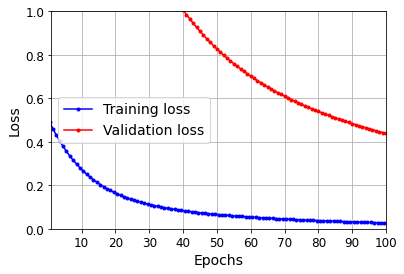

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

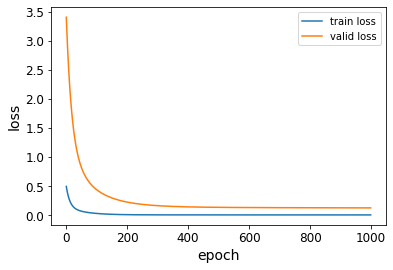

In [23]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='valid loss')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

In [24]:
df_time_train=df_time.iloc[1:41]
df_time_valid=df_time.iloc[41:59]
df_time_test=df_time.iloc[59:]
df_time_trainval=df_time.iloc[:59]

In [25]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

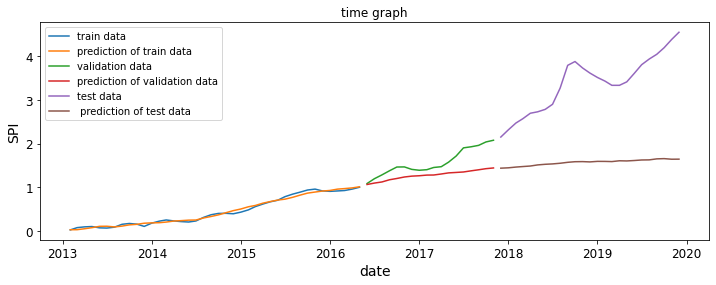

In [26]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

## 모델 2


In [27]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

np.random.seed(120)
tf.random.set_seed(120)

model = Sequential()
model.add(LSTM(15, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics=['mse','mae'])
# 모델을 훈련시킨 후
history = model.fit(train_X, train_y, epochs=1000, batch_size=40, 
        validation_data=(valid_X, valid_y), verbose=2)
#                     ,callbacks=[early_stop])


#최종선택
#Batch = 64
#Encoder = 256
#Decoder = 256
#Epochs = 1000


Epoch 1/1000
1/1 - 0s - loss: 0.3043 - mse: 0.3043 - mae: 0.5103 - val_loss: 1.8951 - val_mse: 1.8951 - val_mae: 1.3585
Epoch 2/1000
1/1 - 0s - loss: 0.2786 - mse: 0.2786 - mae: 0.4855 - val_loss: 1.7935 - val_mse: 1.7935 - val_mae: 1.3208
Epoch 3/1000
1/1 - 0s - loss: 0.2538 - mse: 0.2538 - mae: 0.4606 - val_loss: 1.6944 - val_mse: 1.6944 - val_mae: 1.2829
Epoch 4/1000
1/1 - 0s - loss: 0.2302 - mse: 0.2302 - mae: 0.4355 - val_loss: 1.5978 - val_mse: 1.5978 - val_mae: 1.2449
Epoch 5/1000
1/1 - 0s - loss: 0.2076 - mse: 0.2076 - mae: 0.4102 - val_loss: 1.5040 - val_mse: 1.5040 - val_mae: 1.2067
Epoch 6/1000
1/1 - 0s - loss: 0.1862 - mse: 0.1862 - mae: 0.3848 - val_loss: 1.4128 - val_mse: 1.4128 - val_mae: 1.1685
Epoch 7/1000
1/1 - 0s - loss: 0.1661 - mse: 0.1661 - mae: 0.3594 - val_loss: 1.3245 - val_mse: 1.3245 - val_mae: 1.1301
Epoch 8/1000
1/1 - 0s - loss: 0.1471 - mse: 0.1471 - mae: 0.3338 - val_loss: 1.2391 - val_mse: 1.2391 - val_mae: 1.0918
Epoch 9/1000
1/1 - 0s - loss: 0.1295 - m

Epoch 69/1000
1/1 - 0s - loss: 0.0022 - mse: 0.0022 - mae: 0.0408 - val_loss: 0.1378 - val_mse: 0.1378 - val_mae: 0.3079
Epoch 70/1000
1/1 - 0s - loss: 0.0022 - mse: 0.0022 - mae: 0.0405 - val_loss: 0.1376 - val_mse: 0.1376 - val_mae: 0.3076
Epoch 71/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0402 - val_loss: 0.1376 - val_mse: 0.1376 - val_mae: 0.3076
Epoch 72/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0401 - val_loss: 0.1377 - val_mse: 0.1377 - val_mae: 0.3077
Epoch 73/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0399 - val_loss: 0.1379 - val_mse: 0.1379 - val_mae: 0.3080
Epoch 74/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0398 - val_loss: 0.1382 - val_mse: 0.1382 - val_mae: 0.3085
Epoch 75/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0397 - val_loss: 0.1386 - val_mse: 0.1386 - val_mae: 0.3092
Epoch 76/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0395 - val_loss: 0.1391 - val_mse: 0.1391 - val_mae: 0.3101
Epoch 77/1000
1/1 - 0s - loss: 0

Epoch 137/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0363 - val_loss: 0.1438 - val_mse: 0.1438 - val_mae: 0.3176
Epoch 138/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0363 - val_loss: 0.1438 - val_mse: 0.1438 - val_mae: 0.3177
Epoch 139/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0362 - val_loss: 0.1438 - val_mse: 0.1438 - val_mae: 0.3177
Epoch 140/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0362 - val_loss: 0.1438 - val_mse: 0.1438 - val_mae: 0.3177
Epoch 141/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0362 - val_loss: 0.1438 - val_mse: 0.1438 - val_mae: 0.3177
Epoch 142/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0361 - val_loss: 0.1438 - val_mse: 0.1438 - val_mae: 0.3177
Epoch 143/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0361 - val_loss: 0.1438 - val_mse: 0.1438 - val_mae: 0.3177
Epoch 144/1000
1/1 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0361 - val_loss: 0.1438 - val_mse: 0.1438 - val_mae: 0.3177
Epoch 145/1000
1/1 - 0s 

Epoch 205/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0339 - val_loss: 0.1454 - val_mse: 0.1454 - val_mae: 0.3204
Epoch 206/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0339 - val_loss: 0.1454 - val_mse: 0.1454 - val_mae: 0.3205
Epoch 207/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0338 - val_loss: 0.1455 - val_mse: 0.1455 - val_mae: 0.3206
Epoch 208/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0338 - val_loss: 0.1455 - val_mse: 0.1455 - val_mae: 0.3207
Epoch 209/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0338 - val_loss: 0.1456 - val_mse: 0.1456 - val_mae: 0.3208
Epoch 210/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0337 - val_loss: 0.1456 - val_mse: 0.1456 - val_mae: 0.3209
Epoch 211/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0337 - val_loss: 0.1457 - val_mse: 0.1457 - val_mae: 0.3210
Epoch 212/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - mae: 0.0337 - val_loss: 0.1457 - val_mse: 0.1457 - val_mae: 0.3211
Epoch 213/1000
1/1 - 0s 

Epoch 273/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0315 - val_loss: 0.1501 - val_mse: 0.1501 - val_mae: 0.3282
Epoch 274/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0315 - val_loss: 0.1501 - val_mse: 0.1501 - val_mae: 0.3283
Epoch 275/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0315 - val_loss: 0.1502 - val_mse: 0.1502 - val_mae: 0.3285
Epoch 276/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0314 - val_loss: 0.1503 - val_mse: 0.1503 - val_mae: 0.3286
Epoch 277/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0314 - val_loss: 0.1504 - val_mse: 0.1504 - val_mae: 0.3287
Epoch 278/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0314 - val_loss: 0.1505 - val_mse: 0.1505 - val_mae: 0.3289
Epoch 279/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0313 - val_loss: 0.1506 - val_mse: 0.1506 - val_mae: 0.3290
Epoch 280/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - mae: 0.0313 - val_loss: 0.1506 - val_mse: 0.1506 - val_mae: 0.3291
Epoch 281/1000
1/1 - 0s 

Epoch 341/1000
1/1 - 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0293 - val_loss: 0.1560 - val_mse: 0.1560 - val_mae: 0.3378
Epoch 342/1000
1/1 - 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0292 - val_loss: 0.1561 - val_mse: 0.1561 - val_mae: 0.3379
Epoch 343/1000
1/1 - 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0292 - val_loss: 0.1562 - val_mse: 0.1562 - val_mae: 0.3381
Epoch 344/1000
1/1 - 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0292 - val_loss: 0.1563 - val_mse: 0.1563 - val_mae: 0.3382
Epoch 345/1000
1/1 - 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0291 - val_loss: 0.1564 - val_mse: 0.1564 - val_mae: 0.3384
Epoch 346/1000
1/1 - 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0291 - val_loss: 0.1565 - val_mse: 0.1565 - val_mae: 0.3385
Epoch 347/1000
1/1 - 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0291 - val_loss: 0.1565 - val_mse: 0.1565 - val_mae: 0.3387
Epoch 348/1000
1/1 - 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0290 - val_loss: 0.1566 - val_mse: 0.1566 - val_mae: 0.3388
Epoch 349/1000
1/1 - 0s 

Epoch 408/1000
1/1 - 0s - loss: 9.8601e-04 - mse: 9.8601e-04 - mae: 0.0270 - val_loss: 0.1621 - val_mse: 0.1621 - val_mae: 0.3475
Epoch 409/1000
1/1 - 0s - loss: 9.8397e-04 - mse: 9.8397e-04 - mae: 0.0270 - val_loss: 0.1622 - val_mse: 0.1622 - val_mae: 0.3476
Epoch 410/1000
1/1 - 0s - loss: 9.8193e-04 - mse: 9.8193e-04 - mae: 0.0270 - val_loss: 0.1623 - val_mse: 0.1623 - val_mae: 0.3478
Epoch 411/1000
1/1 - 0s - loss: 9.7991e-04 - mse: 9.7991e-04 - mae: 0.0270 - val_loss: 0.1623 - val_mse: 0.1623 - val_mae: 0.3479
Epoch 412/1000
1/1 - 0s - loss: 9.7789e-04 - mse: 9.7789e-04 - mae: 0.0269 - val_loss: 0.1624 - val_mse: 0.1624 - val_mae: 0.3481
Epoch 413/1000
1/1 - 0s - loss: 9.7587e-04 - mse: 9.7587e-04 - mae: 0.0269 - val_loss: 0.1625 - val_mse: 0.1625 - val_mae: 0.3482
Epoch 414/1000
1/1 - 0s - loss: 9.7386e-04 - mse: 9.7386e-04 - mae: 0.0269 - val_loss: 0.1626 - val_mse: 0.1626 - val_mae: 0.3484
Epoch 415/1000
1/1 - 0s - loss: 9.7186e-04 - mse: 9.7186e-04 - mae: 0.0268 - val_loss: 0.1

Epoch 472/1000
1/1 - 0s - loss: 8.6739e-04 - mse: 8.6739e-04 - mae: 0.0252 - val_loss: 0.1676 - val_mse: 0.1676 - val_mae: 0.3563
Epoch 473/1000
1/1 - 0s - loss: 8.6572e-04 - mse: 8.6572e-04 - mae: 0.0252 - val_loss: 0.1677 - val_mse: 0.1677 - val_mae: 0.3564
Epoch 474/1000
1/1 - 0s - loss: 8.6405e-04 - mse: 8.6405e-04 - mae: 0.0252 - val_loss: 0.1677 - val_mse: 0.1677 - val_mae: 0.3565
Epoch 475/1000
1/1 - 0s - loss: 8.6239e-04 - mse: 8.6239e-04 - mae: 0.0252 - val_loss: 0.1678 - val_mse: 0.1678 - val_mae: 0.3567
Epoch 476/1000
1/1 - 0s - loss: 8.6073e-04 - mse: 8.6073e-04 - mae: 0.0251 - val_loss: 0.1679 - val_mse: 0.1679 - val_mae: 0.3568
Epoch 477/1000
1/1 - 0s - loss: 8.5908e-04 - mse: 8.5908e-04 - mae: 0.0251 - val_loss: 0.1680 - val_mse: 0.1680 - val_mae: 0.3569
Epoch 478/1000
1/1 - 0s - loss: 8.5744e-04 - mse: 8.5744e-04 - mae: 0.0251 - val_loss: 0.1681 - val_mse: 0.1681 - val_mae: 0.3571
Epoch 479/1000
1/1 - 0s - loss: 8.5580e-04 - mse: 8.5580e-04 - mae: 0.0251 - val_loss: 0.1

Epoch 536/1000
1/1 - 0s - loss: 7.7037e-04 - mse: 7.7037e-04 - mae: 0.0236 - val_loss: 0.1724 - val_mse: 0.1724 - val_mae: 0.3640
Epoch 537/1000
1/1 - 0s - loss: 7.6900e-04 - mse: 7.6900e-04 - mae: 0.0235 - val_loss: 0.1725 - val_mse: 0.1725 - val_mae: 0.3641
Epoch 538/1000
1/1 - 0s - loss: 7.6764e-04 - mse: 7.6764e-04 - mae: 0.0235 - val_loss: 0.1725 - val_mse: 0.1725 - val_mae: 0.3642
Epoch 539/1000
1/1 - 0s - loss: 7.6628e-04 - mse: 7.6628e-04 - mae: 0.0235 - val_loss: 0.1726 - val_mse: 0.1726 - val_mae: 0.3643
Epoch 540/1000
1/1 - 0s - loss: 7.6493e-04 - mse: 7.6493e-04 - mae: 0.0235 - val_loss: 0.1727 - val_mse: 0.1727 - val_mae: 0.3644
Epoch 541/1000
1/1 - 0s - loss: 7.6358e-04 - mse: 7.6358e-04 - mae: 0.0234 - val_loss: 0.1727 - val_mse: 0.1727 - val_mae: 0.3645
Epoch 542/1000
1/1 - 0s - loss: 7.6224e-04 - mse: 7.6224e-04 - mae: 0.0234 - val_loss: 0.1728 - val_mse: 0.1728 - val_mae: 0.3647
Epoch 543/1000
1/1 - 0s - loss: 7.6090e-04 - mse: 7.6090e-04 - mae: 0.0234 - val_loss: 0.1

Epoch 600/1000
1/1 - 0s - loss: 6.9123e-04 - mse: 6.9123e-04 - mae: 0.0220 - val_loss: 0.1763 - val_mse: 0.1763 - val_mae: 0.3703
Epoch 601/1000
1/1 - 0s - loss: 6.9012e-04 - mse: 6.9012e-04 - mae: 0.0220 - val_loss: 0.1763 - val_mse: 0.1763 - val_mae: 0.3704
Epoch 602/1000
1/1 - 0s - loss: 6.8901e-04 - mse: 6.8901e-04 - mae: 0.0219 - val_loss: 0.1764 - val_mse: 0.1764 - val_mae: 0.3705
Epoch 603/1000
1/1 - 0s - loss: 6.8790e-04 - mse: 6.8790e-04 - mae: 0.0219 - val_loss: 0.1764 - val_mse: 0.1764 - val_mae: 0.3706
Epoch 604/1000
1/1 - 0s - loss: 6.8680e-04 - mse: 6.8680e-04 - mae: 0.0219 - val_loss: 0.1765 - val_mse: 0.1765 - val_mae: 0.3706
Epoch 605/1000
1/1 - 0s - loss: 6.8570e-04 - mse: 6.8570e-04 - mae: 0.0219 - val_loss: 0.1765 - val_mse: 0.1765 - val_mae: 0.3707
Epoch 606/1000
1/1 - 0s - loss: 6.8461e-04 - mse: 6.8461e-04 - mae: 0.0219 - val_loss: 0.1766 - val_mse: 0.1766 - val_mae: 0.3708
Epoch 607/1000
1/1 - 0s - loss: 6.8352e-04 - mse: 6.8352e-04 - mae: 0.0218 - val_loss: 0.1

Epoch 664/1000
1/1 - 0s - loss: 6.2659e-04 - mse: 6.2659e-04 - mae: 0.0205 - val_loss: 0.1790 - val_mse: 0.1790 - val_mae: 0.3750
Epoch 665/1000
1/1 - 0s - loss: 6.2568e-04 - mse: 6.2568e-04 - mae: 0.0205 - val_loss: 0.1790 - val_mse: 0.1790 - val_mae: 0.3751
Epoch 666/1000
1/1 - 0s - loss: 6.2477e-04 - mse: 6.2477e-04 - mae: 0.0205 - val_loss: 0.1791 - val_mse: 0.1791 - val_mae: 0.3751
Epoch 667/1000
1/1 - 0s - loss: 6.2386e-04 - mse: 6.2386e-04 - mae: 0.0204 - val_loss: 0.1791 - val_mse: 0.1791 - val_mae: 0.3752
Epoch 668/1000
1/1 - 0s - loss: 6.2296e-04 - mse: 6.2296e-04 - mae: 0.0204 - val_loss: 0.1791 - val_mse: 0.1791 - val_mae: 0.3753
Epoch 669/1000
1/1 - 0s - loss: 6.2206e-04 - mse: 6.2206e-04 - mae: 0.0204 - val_loss: 0.1792 - val_mse: 0.1792 - val_mae: 0.3753
Epoch 670/1000
1/1 - 0s - loss: 6.2116e-04 - mse: 6.2116e-04 - mae: 0.0204 - val_loss: 0.1792 - val_mse: 0.1792 - val_mae: 0.3754
Epoch 671/1000
1/1 - 0s - loss: 6.2026e-04 - mse: 6.2026e-04 - mae: 0.0204 - val_loss: 0.1

Epoch 728/1000
1/1 - 0s - loss: 5.7314e-04 - mse: 5.7314e-04 - mae: 0.0193 - val_loss: 0.1806 - val_mse: 0.1806 - val_mae: 0.3781
Epoch 729/1000
1/1 - 0s - loss: 5.7237e-04 - mse: 5.7237e-04 - mae: 0.0193 - val_loss: 0.1806 - val_mse: 0.1806 - val_mae: 0.3781
Epoch 730/1000
1/1 - 0s - loss: 5.7161e-04 - mse: 5.7161e-04 - mae: 0.0193 - val_loss: 0.1806 - val_mse: 0.1806 - val_mae: 0.3782
Epoch 731/1000
1/1 - 0s - loss: 5.7085e-04 - mse: 5.7085e-04 - mae: 0.0193 - val_loss: 0.1806 - val_mse: 0.1806 - val_mae: 0.3782
Epoch 732/1000
1/1 - 0s - loss: 5.7009e-04 - mse: 5.7009e-04 - mae: 0.0192 - val_loss: 0.1806 - val_mse: 0.1806 - val_mae: 0.3782
Epoch 733/1000
1/1 - 0s - loss: 5.6934e-04 - mse: 5.6934e-04 - mae: 0.0192 - val_loss: 0.1807 - val_mse: 0.1807 - val_mae: 0.3783
Epoch 734/1000
1/1 - 0s - loss: 5.6858e-04 - mse: 5.6858e-04 - mae: 0.0192 - val_loss: 0.1807 - val_mse: 0.1807 - val_mae: 0.3783
Epoch 735/1000
1/1 - 0s - loss: 5.6783e-04 - mse: 5.6783e-04 - mae: 0.0192 - val_loss: 0.1

Epoch 792/1000
1/1 - 0s - loss: 5.2770e-04 - mse: 5.2770e-04 - mae: 0.0182 - val_loss: 0.1810 - val_mse: 0.1810 - val_mae: 0.3796
Epoch 793/1000
1/1 - 0s - loss: 5.2703e-04 - mse: 5.2703e-04 - mae: 0.0182 - val_loss: 0.1810 - val_mse: 0.1810 - val_mae: 0.3796
Epoch 794/1000
1/1 - 0s - loss: 5.2637e-04 - mse: 5.2637e-04 - mae: 0.0182 - val_loss: 0.1810 - val_mse: 0.1810 - val_mae: 0.3796
Epoch 795/1000
1/1 - 0s - loss: 5.2571e-04 - mse: 5.2571e-04 - mae: 0.0182 - val_loss: 0.1810 - val_mse: 0.1810 - val_mae: 0.3796
Epoch 796/1000
1/1 - 0s - loss: 5.2506e-04 - mse: 5.2506e-04 - mae: 0.0182 - val_loss: 0.1810 - val_mse: 0.1810 - val_mae: 0.3796
Epoch 797/1000
1/1 - 0s - loss: 5.2440e-04 - mse: 5.2440e-04 - mae: 0.0182 - val_loss: 0.1810 - val_mse: 0.1810 - val_mae: 0.3796
Epoch 798/1000
1/1 - 0s - loss: 5.2374e-04 - mse: 5.2374e-04 - mae: 0.0181 - val_loss: 0.1810 - val_mse: 0.1810 - val_mae: 0.3796
Epoch 799/1000
1/1 - 0s - loss: 5.2309e-04 - mse: 5.2309e-04 - mae: 0.0181 - val_loss: 0.1

Epoch 856/1000
1/1 - 0s - loss: 4.8760e-04 - mse: 4.8760e-04 - mae: 0.0173 - val_loss: 0.1803 - val_mse: 0.1803 - val_mae: 0.3796
Epoch 857/1000
1/1 - 0s - loss: 4.8701e-04 - mse: 4.8701e-04 - mae: 0.0172 - val_loss: 0.1803 - val_mse: 0.1803 - val_mae: 0.3796
Epoch 858/1000
1/1 - 0s - loss: 4.8641e-04 - mse: 4.8641e-04 - mae: 0.0172 - val_loss: 0.1803 - val_mse: 0.1803 - val_mae: 0.3795
Epoch 859/1000
1/1 - 0s - loss: 4.8582e-04 - mse: 4.8582e-04 - mae: 0.0172 - val_loss: 0.1802 - val_mse: 0.1802 - val_mae: 0.3795
Epoch 860/1000
1/1 - 0s - loss: 4.8523e-04 - mse: 4.8523e-04 - mae: 0.0172 - val_loss: 0.1802 - val_mse: 0.1802 - val_mae: 0.3795
Epoch 861/1000
1/1 - 0s - loss: 4.8463e-04 - mse: 4.8463e-04 - mae: 0.0172 - val_loss: 0.1802 - val_mse: 0.1802 - val_mae: 0.3795
Epoch 862/1000
1/1 - 0s - loss: 4.8404e-04 - mse: 4.8404e-04 - mae: 0.0172 - val_loss: 0.1802 - val_mse: 0.1802 - val_mae: 0.3795
Epoch 863/1000
1/1 - 0s - loss: 4.8345e-04 - mse: 4.8345e-04 - mae: 0.0171 - val_loss: 0.1

Epoch 920/1000
1/1 - 0s - loss: 4.5092e-04 - mse: 4.5092e-04 - mae: 0.0164 - val_loss: 0.1786 - val_mse: 0.1786 - val_mae: 0.3783
Epoch 921/1000
1/1 - 0s - loss: 4.5037e-04 - mse: 4.5037e-04 - mae: 0.0164 - val_loss: 0.1786 - val_mse: 0.1786 - val_mae: 0.3783
Epoch 922/1000
1/1 - 0s - loss: 4.4982e-04 - mse: 4.4982e-04 - mae: 0.0164 - val_loss: 0.1786 - val_mse: 0.1786 - val_mae: 0.3783
Epoch 923/1000
1/1 - 0s - loss: 4.4926e-04 - mse: 4.4926e-04 - mae: 0.0164 - val_loss: 0.1785 - val_mse: 0.1785 - val_mae: 0.3782
Epoch 924/1000
1/1 - 0s - loss: 4.4871e-04 - mse: 4.4871e-04 - mae: 0.0163 - val_loss: 0.1785 - val_mse: 0.1785 - val_mae: 0.3782
Epoch 925/1000
1/1 - 0s - loss: 4.4816e-04 - mse: 4.4816e-04 - mae: 0.0163 - val_loss: 0.1785 - val_mse: 0.1785 - val_mae: 0.3782
Epoch 926/1000
1/1 - 0s - loss: 4.4761e-04 - mse: 4.4761e-04 - mae: 0.0163 - val_loss: 0.1784 - val_mse: 0.1784 - val_mae: 0.3781
Epoch 927/1000
1/1 - 0s - loss: 4.4706e-04 - mse: 4.4706e-04 - mae: 0.0163 - val_loss: 0.1

Epoch 984/1000
1/1 - 0s - loss: 4.1637e-04 - mse: 4.1637e-04 - mae: 0.0156 - val_loss: 0.1762 - val_mse: 0.1762 - val_mae: 0.3760
Epoch 985/1000
1/1 - 0s - loss: 4.1584e-04 - mse: 4.1584e-04 - mae: 0.0156 - val_loss: 0.1762 - val_mse: 0.1762 - val_mae: 0.3760
Epoch 986/1000
1/1 - 0s - loss: 4.1531e-04 - mse: 4.1531e-04 - mae: 0.0156 - val_loss: 0.1761 - val_mse: 0.1761 - val_mae: 0.3760
Epoch 987/1000
1/1 - 0s - loss: 4.1479e-04 - mse: 4.1479e-04 - mae: 0.0156 - val_loss: 0.1761 - val_mse: 0.1761 - val_mae: 0.3759
Epoch 988/1000
1/1 - 0s - loss: 4.1426e-04 - mse: 4.1426e-04 - mae: 0.0156 - val_loss: 0.1760 - val_mse: 0.1760 - val_mae: 0.3759
Epoch 989/1000
1/1 - 0s - loss: 4.1373e-04 - mse: 4.1373e-04 - mae: 0.0156 - val_loss: 0.1760 - val_mse: 0.1760 - val_mae: 0.3758
Epoch 990/1000
1/1 - 0s - loss: 4.1321e-04 - mse: 4.1321e-04 - mae: 0.0156 - val_loss: 0.1759 - val_mse: 0.1759 - val_mae: 0.3758
Epoch 991/1000
1/1 - 0s - loss: 4.1268e-04 - mse: 4.1268e-04 - mae: 0.0156 - val_loss: 0.1

In [28]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

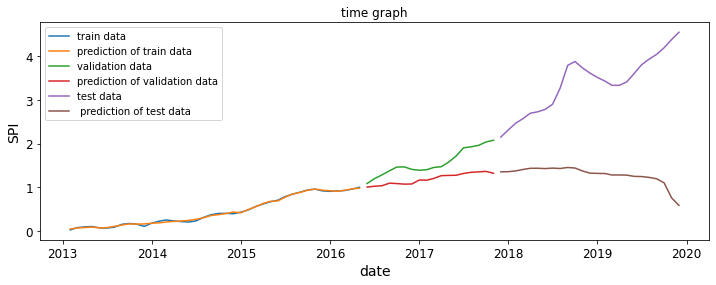

In [29]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

## [2014~2019] LSTM 모델   [layer=2, units=[50,50], optimizer = 'adam', epochs=400, batch_size=23,callbacks=[early_stop]]
## [val_mse: 0.2464 - val_mae: 0.4315]

In [30]:
from keras.callbacks import EarlyStopping 
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

np.random.seed(42)
tf.random.set_seed(42)


model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse','mae'])
history = model.fit(train_X, train_y, epochs=400,
                    validation_data=(valid_X, valid_y),callbacks=[early_stop])

Epoch 1/400
2/2 [==============================] - 0s 203ms/step - loss: 0.4831 - mse: 0.3317 - mae: 0.4831 - val_loss: 1.5346 - val_mse: 2.4374 - val_mae: 1.5346
Epoch 2/400
2/2 [==============================] - 0s 7ms/step - loss: 0.4459 - mse: 0.2985 - mae: 0.4459 - val_loss: 1.4910 - val_mse: 2.3041 - val_mae: 1.4910
Epoch 3/400
2/2 [==============================] - 0s 7ms/step - loss: 0.4100 - mse: 0.2667 - mae: 0.4100 - val_loss: 1.4461 - val_mse: 2.1706 - val_mae: 1.4461
Epoch 4/400
2/2 [==============================] - 0s 8ms/step - loss: 0.3751 - mse: 0.2374 - mae: 0.3751 - val_loss: 1.3962 - val_mse: 2.0266 - val_mae: 1.3962
Epoch 5/400
2/2 [==============================] - 0s 8ms/step - loss: 0.3408 - mse: 0.2093 - mae: 0.3408 - val_loss: 1.3391 - val_mse: 1.8677 - val_mae: 1.3391
Epoch 6/400
2/2 [==============================] - 0s 8ms/step - loss: 0.3135 - mse: 0.1841 - mae: 0.3135 - val_loss: 1.2732 - val_mse: 1.6924 - val_mae: 1.2732
Epoch 7/400
2/2 [===============

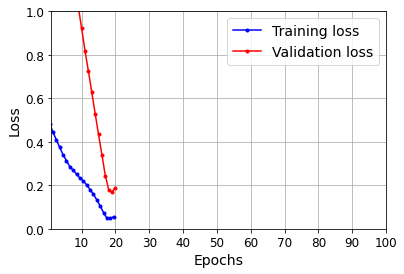

In [31]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

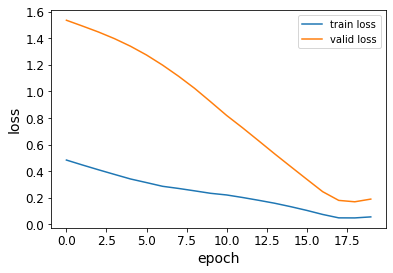

In [32]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='valid loss')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

In [33]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

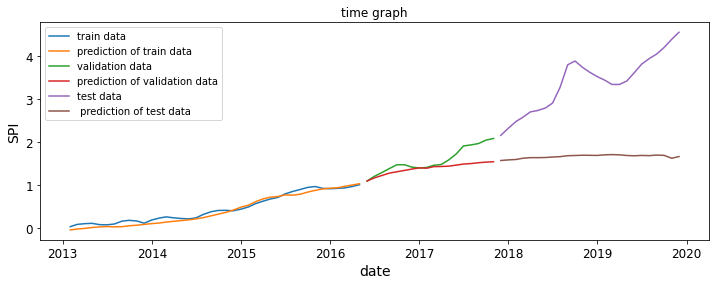

In [34]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

In [35]:
reframed = series_to_supervised(scaled, 12,1)
#t-12~t데이터를 한 행으로 두며 윈도우를 생성한다. (각 변수의 시점을 t-12부터 t까지) 

## t-12~t-1로 t예측

In [36]:
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var9(t-12),var10(t-12),...,var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t)
12,0.470242,1.000000,0.953268,0.000000,1.000000,0.776039,0.871033,0.027437,1.000000,0.020955,...,0.164463,0.796875,0.8,0.249535,0.288950,0.424460,0.394422,0.468354,0.319149,0.179675
13,0.444536,0.775814,0.789852,0.057833,0.989603,0.749878,0.837272,0.071112,0.976563,0.007503,...,0.192838,0.789063,0.8,0.284170,0.323536,0.638489,0.402390,0.481013,0.340426,0.225203
14,0.487270,0.691471,0.823379,0.118526,0.856276,0.715648,0.769750,0.082105,0.960938,0.000000,...,0.296874,0.781250,0.8,0.311961,0.352376,0.568345,0.398406,0.493671,0.354610,0.252033
15,0.276025,0.705427,0.936959,0.298171,0.827575,0.683130,0.735989,0.170171,0.953125,0.003186,...,0.320290,0.789063,0.8,0.353523,0.395249,0.575540,0.406375,0.468354,0.375887,0.230081
16,0.422326,0.632591,0.907349,0.446887,0.798874,0.652078,0.762998,0.183745,0.890625,0.020337,...,0.301684,0.789063,0.8,0.367376,0.408287,0.622302,0.442231,0.481013,0.397163,0.214634


In [37]:
reframed.shape

(72, 299)

In [38]:
# 훈련, 검증, 테스트 데이터셋으로 나누기

# values = reframed.values
# values
train = reframed.iloc[:29,:]
valid = reframed.iloc[29:47,:]
test = reframed.iloc[47:,:]
print(train.head)
print(valid.head)
print(test.head)
train_values = train.values
valid_values = valid.values
test_values = test.values
# print(train_values)
# print(valid_values)
# print(test_values)

<bound method NDFrame.head of     var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12    0.470242    1.000000    0.953268    0.000000    1.000000    0.776039   
13    0.444536    0.775814    0.789852    0.057833    0.989603    0.749878   
14    0.487270    0.691471    0.823379    0.118526    0.856276    0.715648   
15    0.276025    0.705427    0.936959    0.298171    0.827575    0.683130   
16    0.422326    0.632591    0.907349    0.446887    0.798874    0.652078   
17    0.051989    0.594957    0.882347    0.448772    0.693166    0.606601   
18    0.000000    0.666774    0.782921    0.514095    0.736922    0.572127   
19    0.103607    0.676138    0.822367    0.468895    0.729449    0.911736   
20    0.463209    0.569684    0.959003    0.356588    0.722625    1.000000   
21    0.649488    0.547778    0.912245    0.281783    0.738005    0.872127   
22    0.568215    0.586144    0.793971    0.211051    0.743529    0.813447   
23    0.479414    0.464031    0.73

In [39]:
# 훈련, 검증, 테스트 셋 데이터를 x,y로 나누기
train_X, train_y = train_values[:, :-1], train_values[:, -1]
valid_X, valid_y = valid_values[:, :-1], valid_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]

In [40]:
# RNN과 LSTM 학습 시 input값으로 3차원 배열이 필요하므로 3차원으로 변경

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_y = train_y.reshape((train_y.shape[0], 1))

valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
valid_y = valid_y.reshape((valid_y.shape[0], 1))

test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_y = test_y.reshape((test_y.shape[0], 1))


In [41]:
#각 데이터셋의 차원 확인
print(train_X.shape,valid_X.shape,test_X.shape)
print(train_y.shape,valid_y.shape,test_y.shape)

(29, 1, 298) (18, 1, 298) (25, 1, 298)
(29, 1) (18, 1) (25, 1)


## [2014~2019] LSTM 모델 1 [layer=1, units=[150], optimizer = 'adam', epochs=1000,callbacks=[early_stop]]
## [val_mse: 0.0208 - val_mae: 0.1271]

In [42]:
np.random.seed(51)
tf.random.set_seed(51)
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model = Sequential()
model.add(LSTM(150,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse','mae'])
# 모델을 훈련시킨 후
history = model.fit(train_X, train_y, epochs=1000, 
        validation_data=(valid_X, valid_y), verbose=2,callbacks=[early_stop])

Epoch 1/1000
1/1 - 0s - loss: 0.4700 - mse: 0.3257 - mae: 0.4700 - val_loss: 0.6273 - val_mse: 0.4377 - val_mae: 0.6273
Epoch 2/1000
1/1 - 0s - loss: 0.3189 - mse: 0.1322 - mae: 0.3189 - val_loss: 0.1265 - val_mse: 0.0208 - val_mae: 0.1265
Epoch 3/1000
1/1 - 0s - loss: 0.4675 - mse: 0.2537 - mae: 0.4675 - val_loss: 0.1271 - val_mse: 0.0208 - val_mae: 0.1271
Epoch 00003: early stopping


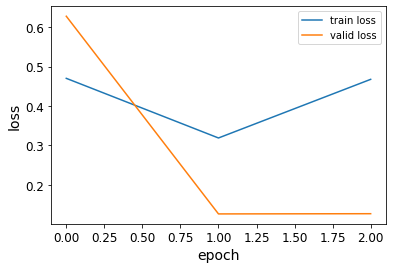

In [43]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='valid loss')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

In [45]:
df_time_train=df_time.iloc[12:41]
df_time_valid=df_time.iloc[41:59]
df_time_test=df_time.iloc[59:]
df_time_trainval=df_time.iloc[:59]

In [46]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

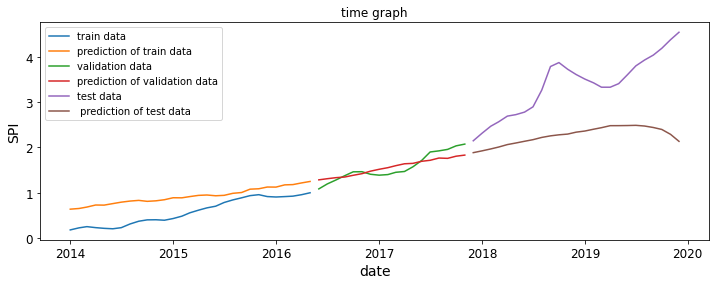

In [47]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

## [2014~2019] LSTM 모델 2 [layer=1, units=[150], optimizer = 'adam', epochs=1000,callbacks=[early_stop]]
## [val_mse: 0.0158 - val_mae: 0.1131]

In [53]:
np.random.seed(57)
tf.random.set_seed(57)

model = Sequential()
model.add(LSTM(150,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse','mae'])
# 모델을 훈련시킨 후
history = model.fit(train_X, train_y, epochs=1000, 
        validation_data=(valid_X, valid_y), verbose=2,callbacks=[early_stop])

Epoch 1/1000
1/1 - 0s - loss: 0.5779 - mse: 0.3893 - mae: 0.5779 - val_loss: 0.6653 - val_mse: 0.4718 - val_mae: 0.6653
Epoch 2/1000
1/1 - 0s - loss: 0.2097 - mse: 0.0508 - mae: 0.2097 - val_loss: 0.1122 - val_mse: 0.0149 - val_mae: 0.1122
Epoch 3/1000
1/1 - 0s - loss: 0.3635 - mse: 0.1454 - mae: 0.3635 - val_loss: 0.1131 - val_mse: 0.0158 - val_mae: 0.1131
Epoch 4/1000
1/1 - 0s - loss: 0.2940 - mse: 0.0919 - mae: 0.2940 - val_loss: 0.1693 - val_mse: 0.0459 - val_mae: 0.1693
Epoch 5/1000
1/1 - 0s - loss: 0.0839 - mse: 0.0099 - mae: 0.0839 - val_loss: 0.3960 - val_mse: 0.1786 - val_mae: 0.3960
Epoch 6/1000
1/1 - 0s - loss: 0.1698 - mse: 0.0330 - mae: 0.1698 - val_loss: 0.4321 - val_mse: 0.2096 - val_mae: 0.4321
Epoch 7/1000
1/1 - 0s - loss: 0.2399 - mse: 0.0625 - mae: 0.2399 - val_loss: 0.3511 - val_mse: 0.1456 - val_mae: 0.3511
Epoch 8/1000
1/1 - 0s - loss: 0.2020 - mse: 0.0471 - mae: 0.2020 - val_loss: 0.1928 - val_mse: 0.0582 - val_mae: 0.1928


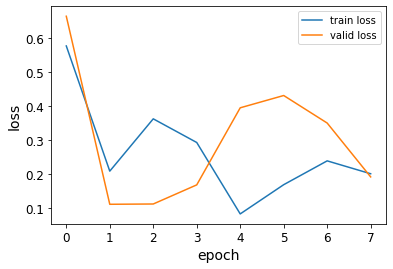

In [54]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='valid loss')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

In [55]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

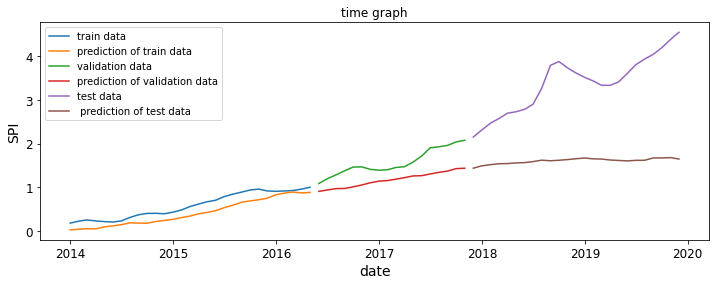

In [56]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

## [2014~2019] LSTM 모델 3 [layer=1, units=[100], optimizer = 'adam', epochs=300,callbacks=[early_stop]]
##  [val_mse: 0.0160 - val_mae: 0.1074]

In [57]:
np.random.seed(66)
tf.random.set_seed(66)

model = Sequential()
model.add(LSTM(100,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics=['mse','mae'])
# 모델을 훈련시킨 후
history = model.fit(train_X, train_y, epochs=300, 
        validation_data=(valid_X, valid_y), verbose=2
                    ,callbacks=[early_stop])

Epoch 1/300
1/1 - 0s - loss: 0.3538 - mse: 0.3538 - mae: 0.5189 - val_loss: 0.6773 - val_mse: 0.6773 - val_mae: 0.7989
Epoch 2/300
1/1 - 0s - loss: 0.0727 - mse: 0.0727 - mae: 0.2479 - val_loss: 0.0945 - val_mse: 0.0945 - val_mae: 0.2687
Epoch 3/300
1/1 - 0s - loss: 0.1118 - mse: 0.1118 - mae: 0.2795 - val_loss: 0.0160 - val_mse: 0.0160 - val_mae: 0.1074
Epoch 4/300
1/1 - 0s - loss: 0.1241 - mse: 0.1241 - mae: 0.3368 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1191
Epoch 5/300
1/1 - 0s - loss: 0.0670 - mse: 0.0670 - mae: 0.2528 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.1061
Epoch 6/300
1/1 - 0s - loss: 0.0154 - mse: 0.0154 - mae: 0.1094 - val_loss: 0.0272 - val_mse: 0.0272 - val_mae: 0.1240
Epoch 7/300
1/1 - 0s - loss: 0.0080 - mse: 0.0080 - mae: 0.0807 - val_loss: 0.0524 - val_mse: 0.0524 - val_mae: 0.1855
Epoch 8/300
1/1 - 0s - loss: 0.0319 - mse: 0.0319 - mae: 0.1635 - val_loss: 0.0735 - val_mse: 0.0735 - val_mae: 0.2319
Epoch 9/300
1/1 - 0s - loss: 0.0536 - mse: 0.053

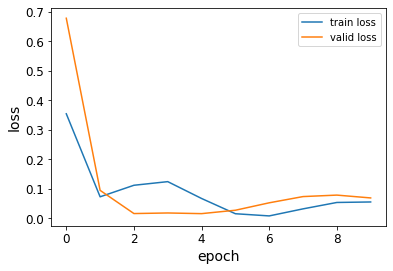

In [58]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='valid loss')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

In [59]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

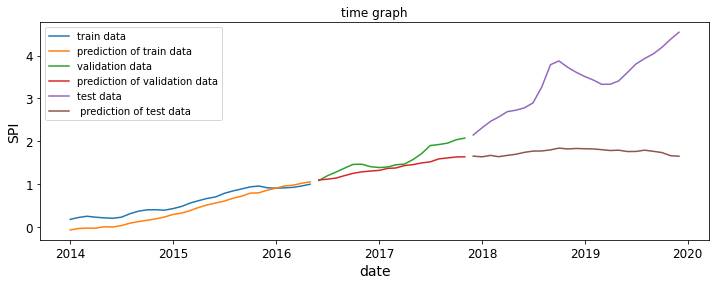

In [60]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

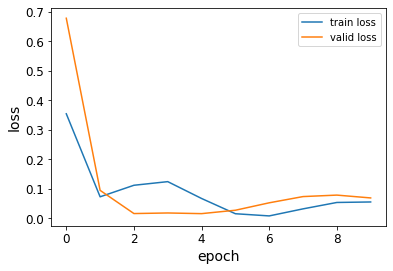

In [61]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='valid loss')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

In [62]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

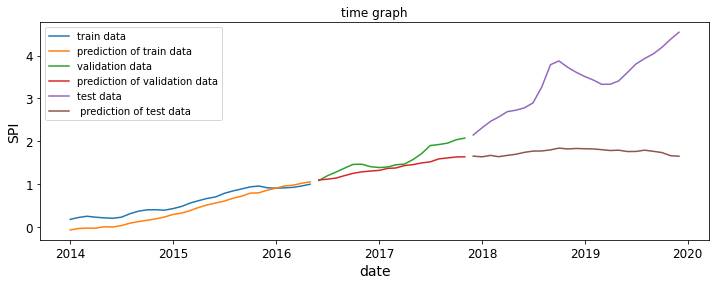

In [63]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

## [2014~2019] LSTM 모델 4 [layer=1, units=[15], optimizer = 'adam', epochs=1000,callbacks=[early_stop]]
## [val_mse: 0.1273 - val_mae: 0.3011]

In [64]:
np.random.seed(18)
tf.random.set_seed(18)
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

model = Sequential()
model.add(LSTM(15,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse','mae'])
# 모델을 훈련시킨 후
history = model.fit(train_X, train_y, epochs=1000, 
        validation_data=(valid_X, valid_y), verbose=2,callbacks=[early_stop])

Epoch 1/1000
1/1 - 0s - loss: 0.6440 - mse: 0.5666 - mae: 0.6440 - val_loss: 1.7505 - val_mse: 3.2155 - val_mae: 1.7505
Epoch 2/1000
1/1 - 0s - loss: 0.4743 - mse: 0.3736 - mae: 0.4743 - val_loss: 1.5275 - val_mse: 2.4595 - val_mae: 1.5275
Epoch 3/1000
1/1 - 0s - loss: 0.3871 - mse: 0.2469 - mae: 0.3871 - val_loss: 1.3166 - val_mse: 1.8369 - val_mae: 1.3166
Epoch 4/1000
1/1 - 0s - loss: 0.3472 - mse: 0.1735 - mae: 0.3472 - val_loss: 1.1266 - val_mse: 1.3546 - val_mae: 1.1266
Epoch 5/1000
1/1 - 0s - loss: 0.3172 - mse: 0.1298 - mae: 0.3172 - val_loss: 0.9549 - val_mse: 0.9831 - val_mae: 0.9549
Epoch 6/1000
1/1 - 0s - loss: 0.2874 - mse: 0.1004 - mae: 0.2874 - val_loss: 0.8046 - val_mse: 0.7078 - val_mae: 0.8046
Epoch 7/1000
1/1 - 0s - loss: 0.2589 - mse: 0.0784 - mae: 0.2589 - val_loss: 0.6742 - val_mse: 0.5070 - val_mae: 0.6742
Epoch 8/1000
1/1 - 0s - loss: 0.2259 - mse: 0.0600 - mae: 0.2259 - val_loss: 0.5581 - val_mse: 0.3579 - val_mae: 0.5581
Epoch 9/1000
1/1 - 0s - loss: 0.1902 - m

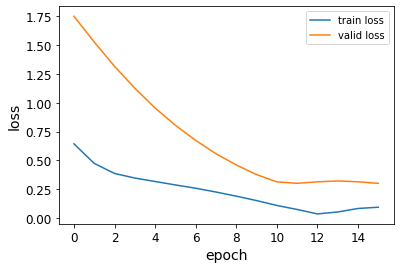

In [65]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='valid loss')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

In [66]:
df_time_train=df_time.iloc[12:41]
df_time_valid=df_time.iloc[41:59]
df_time_test=df_time.iloc[59:]
df_time_trainval=df_time.iloc[:59]

In [67]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

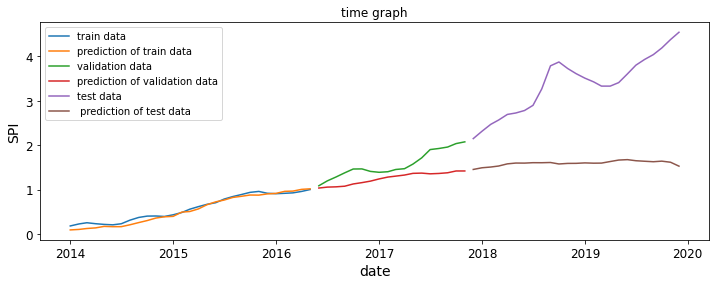

In [68]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

## 복층 LSTM 모델 빌드

In [69]:
np.random.seed(52)
tf.random.set_seed(52)

model = Sequential()
model.add(LSTM(30, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(30, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics=['mse','mae'])

model.fit(train_X, train_y, epochs=1000, batch_size=29, validation_data=(valid_X, valid_y), verbose=2)

Epoch 1/1000
1/1 - 1s - loss: 0.4236 - mse: 0.4236 - mae: 0.5818 - val_loss: 2.5135 - val_mse: 2.5135 - val_mae: 1.5587
Epoch 2/1000
1/1 - 0s - loss: 0.4128 - mse: 0.4128 - mae: 0.5725 - val_loss: 2.4793 - val_mse: 2.4793 - val_mae: 1.5478
Epoch 3/1000
1/1 - 0s - loss: 0.4021 - mse: 0.4021 - mae: 0.5631 - val_loss: 2.4456 - val_mse: 2.4456 - val_mae: 1.5370
Epoch 4/1000
1/1 - 0s - loss: 0.3911 - mse: 0.3911 - mae: 0.5533 - val_loss: 2.4113 - val_mse: 2.4113 - val_mae: 1.5258
Epoch 5/1000
1/1 - 0s - loss: 0.3796 - mse: 0.3796 - mae: 0.5427 - val_loss: 2.3753 - val_mse: 2.3753 - val_mae: 1.5141
Epoch 6/1000
1/1 - 0s - loss: 0.3675 - mse: 0.3675 - mae: 0.5314 - val_loss: 2.3371 - val_mse: 2.3371 - val_mae: 1.5014
Epoch 7/1000
1/1 - 0s - loss: 0.3548 - mse: 0.3548 - mae: 0.5192 - val_loss: 2.2963 - val_mse: 2.2963 - val_mae: 1.4879
Epoch 8/1000
1/1 - 0s - loss: 0.3414 - mse: 0.3414 - mae: 0.5061 - val_loss: 2.2531 - val_mse: 2.2531 - val_mae: 1.4734
Epoch 9/1000
1/1 - 0s - loss: 0.3275 - m

Epoch 69/1000
1/1 - 0s - loss: 0.0027 - mse: 0.0027 - mae: 0.0430 - val_loss: 0.3489 - val_mse: 0.3489 - val_mae: 0.5192
Epoch 70/1000
1/1 - 0s - loss: 0.0033 - mse: 0.0033 - mae: 0.0473 - val_loss: 0.3422 - val_mse: 0.3422 - val_mae: 0.5127
Epoch 71/1000
1/1 - 0s - loss: 0.0037 - mse: 0.0037 - mae: 0.0497 - val_loss: 0.3379 - val_mse: 0.3379 - val_mae: 0.5087
Epoch 72/1000
1/1 - 0s - loss: 0.0038 - mse: 0.0038 - mae: 0.0504 - val_loss: 0.3361 - val_mse: 0.3361 - val_mae: 0.5071
Epoch 73/1000
1/1 - 0s - loss: 0.0037 - mse: 0.0037 - mae: 0.0493 - val_loss: 0.3364 - val_mse: 0.3364 - val_mae: 0.5077
Epoch 74/1000
1/1 - 0s - loss: 0.0034 - mse: 0.0034 - mae: 0.0469 - val_loss: 0.3391 - val_mse: 0.3391 - val_mae: 0.5108
Epoch 75/1000
1/1 - 0s - loss: 0.0030 - mse: 0.0030 - mae: 0.0442 - val_loss: 0.3447 - val_mse: 0.3447 - val_mae: 0.5166
Epoch 76/1000
1/1 - 0s - loss: 0.0025 - mse: 0.0025 - mae: 0.0407 - val_loss: 0.3543 - val_mse: 0.3543 - val_mae: 0.5260
Epoch 77/1000
1/1 - 0s - loss: 0

Epoch 134/1000
1/1 - 0s - loss: 7.0589e-04 - mse: 7.0589e-04 - mae: 0.0220 - val_loss: 0.4157 - val_mse: 0.4157 - val_mae: 0.5794
Epoch 135/1000
1/1 - 0s - loss: 7.0209e-04 - mse: 7.0209e-04 - mae: 0.0220 - val_loss: 0.4156 - val_mse: 0.4156 - val_mae: 0.5794
Epoch 136/1000
1/1 - 0s - loss: 6.9811e-04 - mse: 6.9811e-04 - mae: 0.0220 - val_loss: 0.4156 - val_mse: 0.4156 - val_mae: 0.5794
Epoch 137/1000
1/1 - 0s - loss: 6.9400e-04 - mse: 6.9400e-04 - mae: 0.0219 - val_loss: 0.4157 - val_mse: 0.4157 - val_mae: 0.5794
Epoch 138/1000
1/1 - 0s - loss: 6.8985e-04 - mse: 6.8985e-04 - mae: 0.0219 - val_loss: 0.4157 - val_mse: 0.4157 - val_mae: 0.5795
Epoch 139/1000
1/1 - 0s - loss: 6.8575e-04 - mse: 6.8575e-04 - mae: 0.0219 - val_loss: 0.4158 - val_mse: 0.4158 - val_mae: 0.5796
Epoch 140/1000
1/1 - 0s - loss: 6.8178e-04 - mse: 6.8178e-04 - mae: 0.0218 - val_loss: 0.4159 - val_mse: 0.4159 - val_mae: 0.5796
Epoch 141/1000
1/1 - 0s - loss: 6.7800e-04 - mse: 6.7800e-04 - mae: 0.0218 - val_loss: 0.4

Epoch 198/1000
1/1 - 0s - loss: 5.0719e-04 - mse: 5.0719e-04 - mae: 0.0189 - val_loss: 0.4125 - val_mse: 0.4125 - val_mae: 0.5773
Epoch 199/1000
1/1 - 0s - loss: 5.0381e-04 - mse: 5.0381e-04 - mae: 0.0188 - val_loss: 0.4123 - val_mse: 0.4123 - val_mae: 0.5771
Epoch 200/1000
1/1 - 0s - loss: 5.0039e-04 - mse: 5.0039e-04 - mae: 0.0188 - val_loss: 0.4121 - val_mse: 0.4121 - val_mae: 0.5770
Epoch 201/1000
1/1 - 0s - loss: 4.9694e-04 - mse: 4.9694e-04 - mae: 0.0187 - val_loss: 0.4119 - val_mse: 0.4119 - val_mae: 0.5769
Epoch 202/1000
1/1 - 0s - loss: 4.9346e-04 - mse: 4.9346e-04 - mae: 0.0186 - val_loss: 0.4118 - val_mse: 0.4118 - val_mae: 0.5767
Epoch 203/1000
1/1 - 0s - loss: 4.8995e-04 - mse: 4.8995e-04 - mae: 0.0186 - val_loss: 0.4116 - val_mse: 0.4116 - val_mae: 0.5766
Epoch 204/1000
1/1 - 0s - loss: 4.8641e-04 - mse: 4.8641e-04 - mae: 0.0185 - val_loss: 0.4114 - val_mse: 0.4114 - val_mae: 0.5765
Epoch 205/1000
1/1 - 0s - loss: 4.8283e-04 - mse: 4.8283e-04 - mae: 0.0184 - val_loss: 0.4

Epoch 262/1000
1/1 - 0s - loss: 2.5119e-04 - mse: 2.5119e-04 - mae: 0.0133 - val_loss: 0.3988 - val_mse: 0.3988 - val_mae: 0.5672
Epoch 263/1000
1/1 - 0s - loss: 2.4671e-04 - mse: 2.4671e-04 - mae: 0.0131 - val_loss: 0.3985 - val_mse: 0.3985 - val_mae: 0.5670
Epoch 264/1000
1/1 - 0s - loss: 2.4221e-04 - mse: 2.4221e-04 - mae: 0.0130 - val_loss: 0.3982 - val_mse: 0.3982 - val_mae: 0.5668
Epoch 265/1000
1/1 - 0s - loss: 2.3769e-04 - mse: 2.3769e-04 - mae: 0.0129 - val_loss: 0.3979 - val_mse: 0.3979 - val_mae: 0.5665
Epoch 266/1000
1/1 - 0s - loss: 2.3316e-04 - mse: 2.3316e-04 - mae: 0.0127 - val_loss: 0.3976 - val_mse: 0.3976 - val_mae: 0.5663
Epoch 267/1000
1/1 - 0s - loss: 2.2861e-04 - mse: 2.2861e-04 - mae: 0.0126 - val_loss: 0.3973 - val_mse: 0.3973 - val_mae: 0.5660
Epoch 268/1000
1/1 - 0s - loss: 2.2406e-04 - mse: 2.2406e-04 - mae: 0.0124 - val_loss: 0.3970 - val_mse: 0.3970 - val_mae: 0.5658
Epoch 269/1000
1/1 - 0s - loss: 2.1951e-04 - mse: 2.1951e-04 - mae: 0.0123 - val_loss: 0.3

Epoch 326/1000
1/1 - 0s - loss: 8.7696e-05 - mse: 8.7696e-05 - mae: 0.0075 - val_loss: 0.3894 - val_mse: 0.3894 - val_mae: 0.5609
Epoch 327/1000
1/1 - 0s - loss: 8.6557e-05 - mse: 8.6557e-05 - mae: 0.0074 - val_loss: 0.3894 - val_mse: 0.3894 - val_mae: 0.5609
Epoch 328/1000
1/1 - 0s - loss: 8.5433e-05 - mse: 8.5433e-05 - mae: 0.0074 - val_loss: 0.3894 - val_mse: 0.3894 - val_mae: 0.5609
Epoch 329/1000
1/1 - 0s - loss: 8.4326e-05 - mse: 8.4326e-05 - mae: 0.0074 - val_loss: 0.3894 - val_mse: 0.3894 - val_mae: 0.5609
Epoch 330/1000
1/1 - 0s - loss: 8.3235e-05 - mse: 8.3235e-05 - mae: 0.0073 - val_loss: 0.3893 - val_mse: 0.3893 - val_mae: 0.5609
Epoch 331/1000
1/1 - 0s - loss: 8.2158e-05 - mse: 8.2158e-05 - mae: 0.0073 - val_loss: 0.3893 - val_mse: 0.3893 - val_mae: 0.5609
Epoch 332/1000
1/1 - 0s - loss: 8.1096e-05 - mse: 8.1096e-05 - mae: 0.0072 - val_loss: 0.3893 - val_mse: 0.3893 - val_mae: 0.5609
Epoch 333/1000
1/1 - 0s - loss: 8.0049e-05 - mse: 8.0049e-05 - mae: 0.0072 - val_loss: 0.3

Epoch 390/1000
1/1 - 0s - loss: 3.7226e-05 - mse: 3.7226e-05 - mae: 0.0048 - val_loss: 0.3928 - val_mse: 0.3928 - val_mae: 0.5644
Epoch 391/1000
1/1 - 0s - loss: 3.6696e-05 - mse: 3.6696e-05 - mae: 0.0048 - val_loss: 0.3929 - val_mse: 0.3929 - val_mae: 0.5645
Epoch 392/1000
1/1 - 0s - loss: 3.6172e-05 - mse: 3.6172e-05 - mae: 0.0048 - val_loss: 0.3930 - val_mse: 0.3930 - val_mae: 0.5646
Epoch 393/1000
1/1 - 0s - loss: 3.5654e-05 - mse: 3.5654e-05 - mae: 0.0047 - val_loss: 0.3932 - val_mse: 0.3932 - val_mae: 0.5648
Epoch 394/1000
1/1 - 0s - loss: 3.5142e-05 - mse: 3.5142e-05 - mae: 0.0047 - val_loss: 0.3933 - val_mse: 0.3933 - val_mae: 0.5649
Epoch 395/1000
1/1 - 0s - loss: 3.4635e-05 - mse: 3.4635e-05 - mae: 0.0047 - val_loss: 0.3935 - val_mse: 0.3935 - val_mae: 0.5650
Epoch 396/1000
1/1 - 0s - loss: 3.4133e-05 - mse: 3.4133e-05 - mae: 0.0046 - val_loss: 0.3936 - val_mse: 0.3936 - val_mae: 0.5651
Epoch 397/1000
1/1 - 0s - loss: 3.3637e-05 - mse: 3.3637e-05 - mae: 0.0046 - val_loss: 0.3

Epoch 454/1000
1/1 - 0s - loss: 1.3205e-05 - mse: 1.3205e-05 - mae: 0.0030 - val_loss: 0.4030 - val_mse: 0.4030 - val_mae: 0.5721
Epoch 455/1000
1/1 - 0s - loss: 1.2970e-05 - mse: 1.2970e-05 - mae: 0.0030 - val_loss: 0.4031 - val_mse: 0.4031 - val_mae: 0.5722
Epoch 456/1000
1/1 - 0s - loss: 1.2739e-05 - mse: 1.2739e-05 - mae: 0.0030 - val_loss: 0.4032 - val_mse: 0.4032 - val_mae: 0.5723
Epoch 457/1000
1/1 - 0s - loss: 1.2511e-05 - mse: 1.2511e-05 - mae: 0.0029 - val_loss: 0.4034 - val_mse: 0.4034 - val_mae: 0.5724
Epoch 458/1000
1/1 - 0s - loss: 1.2288e-05 - mse: 1.2288e-05 - mae: 0.0029 - val_loss: 0.4035 - val_mse: 0.4035 - val_mae: 0.5724
Epoch 459/1000
1/1 - 0s - loss: 1.2068e-05 - mse: 1.2068e-05 - mae: 0.0029 - val_loss: 0.4036 - val_mse: 0.4036 - val_mae: 0.5725
Epoch 460/1000
1/1 - 0s - loss: 1.1851e-05 - mse: 1.1851e-05 - mae: 0.0029 - val_loss: 0.4037 - val_mse: 0.4037 - val_mae: 0.5726
Epoch 461/1000
1/1 - 0s - loss: 1.1638e-05 - mse: 1.1638e-05 - mae: 0.0028 - val_loss: 0.4

1/1 - 0s - loss: 4.2248e-06 - mse: 4.2248e-06 - mae: 0.0016 - val_loss: 0.4064 - val_mse: 0.4064 - val_mae: 0.5740
Epoch 518/1000
1/1 - 0s - loss: 4.1516e-06 - mse: 4.1516e-06 - mae: 0.0016 - val_loss: 0.4064 - val_mse: 0.4064 - val_mae: 0.5740
Epoch 519/1000
1/1 - 0s - loss: 4.0796e-06 - mse: 4.0796e-06 - mae: 0.0016 - val_loss: 0.4064 - val_mse: 0.4064 - val_mae: 0.5740
Epoch 520/1000
1/1 - 0s - loss: 4.0091e-06 - mse: 4.0091e-06 - mae: 0.0016 - val_loss: 0.4064 - val_mse: 0.4064 - val_mae: 0.5740
Epoch 521/1000
1/1 - 0s - loss: 3.9400e-06 - mse: 3.9400e-06 - mae: 0.0015 - val_loss: 0.4064 - val_mse: 0.4064 - val_mae: 0.5740
Epoch 522/1000
1/1 - 0s - loss: 3.8722e-06 - mse: 3.8722e-06 - mae: 0.0015 - val_loss: 0.4064 - val_mse: 0.4064 - val_mae: 0.5740
Epoch 523/1000
1/1 - 0s - loss: 3.8056e-06 - mse: 3.8056e-06 - mae: 0.0015 - val_loss: 0.4064 - val_mse: 0.4064 - val_mae: 0.5740
Epoch 524/1000
1/1 - 0s - loss: 3.7404e-06 - mse: 3.7404e-06 - mae: 0.0015 - val_loss: 0.4064 - val_mse: 

Epoch 580/1000
1/1 - 0s - loss: 1.5075e-06 - mse: 1.5075e-06 - mae: 9.0479e-04 - val_loss: 0.4057 - val_mse: 0.4057 - val_mae: 0.5732
Epoch 581/1000
1/1 - 0s - loss: 1.4848e-06 - mse: 1.4848e-06 - mae: 8.9777e-04 - val_loss: 0.4057 - val_mse: 0.4057 - val_mae: 0.5732
Epoch 582/1000
1/1 - 0s - loss: 1.4626e-06 - mse: 1.4626e-06 - mae: 8.9082e-04 - val_loss: 0.4057 - val_mse: 0.4057 - val_mae: 0.5732
Epoch 583/1000
1/1 - 0s - loss: 1.4407e-06 - mse: 1.4407e-06 - mae: 8.8390e-04 - val_loss: 0.4056 - val_mse: 0.4056 - val_mae: 0.5732
Epoch 584/1000
1/1 - 0s - loss: 1.4191e-06 - mse: 1.4191e-06 - mae: 8.7706e-04 - val_loss: 0.4056 - val_mse: 0.4056 - val_mae: 0.5731
Epoch 585/1000
1/1 - 0s - loss: 1.3980e-06 - mse: 1.3980e-06 - mae: 8.7030e-04 - val_loss: 0.4056 - val_mse: 0.4056 - val_mae: 0.5731
Epoch 586/1000
1/1 - 0s - loss: 1.3772e-06 - mse: 1.3772e-06 - mae: 8.6355e-04 - val_loss: 0.4056 - val_mse: 0.4056 - val_mae: 0.5731
Epoch 587/1000
1/1 - 0s - loss: 1.3568e-06 - mse: 1.3568e-06 -

Epoch 642/1000
1/1 - 0s - loss: 6.2730e-07 - mse: 6.2730e-07 - mae: 5.7277e-04 - val_loss: 0.4050 - val_mse: 0.4050 - val_mae: 0.5725
Epoch 643/1000
1/1 - 0s - loss: 6.1907e-07 - mse: 6.1907e-07 - mae: 5.6941e-04 - val_loss: 0.4050 - val_mse: 0.4050 - val_mae: 0.5725
Epoch 644/1000
1/1 - 0s - loss: 6.1097e-07 - mse: 6.1097e-07 - mae: 5.6610e-04 - val_loss: 0.4050 - val_mse: 0.4050 - val_mae: 0.5725
Epoch 645/1000
1/1 - 0s - loss: 6.0298e-07 - mse: 6.0298e-07 - mae: 5.6277e-04 - val_loss: 0.4050 - val_mse: 0.4050 - val_mae: 0.5725
Epoch 646/1000
1/1 - 0s - loss: 5.9513e-07 - mse: 5.9513e-07 - mae: 5.5946e-04 - val_loss: 0.4050 - val_mse: 0.4050 - val_mae: 0.5725
Epoch 647/1000
1/1 - 0s - loss: 5.8741e-07 - mse: 5.8741e-07 - mae: 5.5618e-04 - val_loss: 0.4050 - val_mse: 0.4050 - val_mae: 0.5725
Epoch 648/1000
1/1 - 0s - loss: 5.7980e-07 - mse: 5.7980e-07 - mae: 5.5294e-04 - val_loss: 0.4050 - val_mse: 0.4050 - val_mae: 0.5725
Epoch 649/1000
1/1 - 0s - loss: 5.7227e-07 - mse: 5.7227e-07 -

Epoch 704/1000
1/1 - 0s - loss: 2.9000e-07 - mse: 2.9000e-07 - mae: 3.9883e-04 - val_loss: 0.4046 - val_mse: 0.4046 - val_mae: 0.5722
Epoch 705/1000
1/1 - 0s - loss: 2.8662e-07 - mse: 2.8662e-07 - mae: 3.9669e-04 - val_loss: 0.4046 - val_mse: 0.4046 - val_mae: 0.5722
Epoch 706/1000
1/1 - 0s - loss: 2.8329e-07 - mse: 2.8329e-07 - mae: 3.9454e-04 - val_loss: 0.4046 - val_mse: 0.4046 - val_mae: 0.5722
Epoch 707/1000
1/1 - 0s - loss: 2.7999e-07 - mse: 2.7999e-07 - mae: 3.9240e-04 - val_loss: 0.4046 - val_mse: 0.4046 - val_mae: 0.5722
Epoch 708/1000
1/1 - 0s - loss: 2.7675e-07 - mse: 2.7675e-07 - mae: 3.9028e-04 - val_loss: 0.4046 - val_mse: 0.4046 - val_mae: 0.5722
Epoch 709/1000
1/1 - 0s - loss: 2.7355e-07 - mse: 2.7355e-07 - mae: 3.8816e-04 - val_loss: 0.4046 - val_mse: 0.4046 - val_mae: 0.5722
Epoch 710/1000
1/1 - 0s - loss: 2.7038e-07 - mse: 2.7038e-07 - mae: 3.8604e-04 - val_loss: 0.4046 - val_mse: 0.4046 - val_mae: 0.5722
Epoch 711/1000
1/1 - 0s - loss: 2.6728e-07 - mse: 2.6728e-07 -

Epoch 766/1000
1/1 - 0s - loss: 1.4540e-07 - mse: 1.4540e-07 - mae: 2.8475e-04 - val_loss: 0.4044 - val_mse: 0.4044 - val_mae: 0.5720
Epoch 767/1000
1/1 - 0s - loss: 1.4389e-07 - mse: 1.4389e-07 - mae: 2.8322e-04 - val_loss: 0.4044 - val_mse: 0.4044 - val_mae: 0.5720
Epoch 768/1000
1/1 - 0s - loss: 1.4236e-07 - mse: 1.4236e-07 - mae: 2.8166e-04 - val_loss: 0.4044 - val_mse: 0.4044 - val_mae: 0.5720
Epoch 769/1000
1/1 - 0s - loss: 1.4087e-07 - mse: 1.4087e-07 - mae: 2.8012e-04 - val_loss: 0.4044 - val_mse: 0.4044 - val_mae: 0.5720
Epoch 770/1000
1/1 - 0s - loss: 1.3941e-07 - mse: 1.3941e-07 - mae: 2.7862e-04 - val_loss: 0.4044 - val_mse: 0.4044 - val_mae: 0.5720
Epoch 771/1000
1/1 - 0s - loss: 1.3795e-07 - mse: 1.3795e-07 - mae: 2.7711e-04 - val_loss: 0.4044 - val_mse: 0.4044 - val_mae: 0.5720
Epoch 772/1000
1/1 - 0s - loss: 1.3650e-07 - mse: 1.3650e-07 - mae: 2.7560e-04 - val_loss: 0.4044 - val_mse: 0.4044 - val_mae: 0.5720
Epoch 773/1000
1/1 - 0s - loss: 1.3510e-07 - mse: 1.3510e-07 -

Epoch 828/1000
1/1 - 0s - loss: 7.7792e-08 - mse: 7.7792e-08 - mae: 2.0328e-04 - val_loss: 0.4043 - val_mse: 0.4043 - val_mae: 0.5719
Epoch 829/1000
1/1 - 0s - loss: 7.7047e-08 - mse: 7.7047e-08 - mae: 2.0223e-04 - val_loss: 0.4043 - val_mse: 0.4043 - val_mae: 0.5719
Epoch 830/1000
1/1 - 0s - loss: 7.6311e-08 - mse: 7.6311e-08 - mae: 2.0110e-04 - val_loss: 0.4043 - val_mse: 0.4043 - val_mae: 0.5718
Epoch 831/1000
1/1 - 0s - loss: 7.5574e-08 - mse: 7.5574e-08 - mae: 2.0001e-04 - val_loss: 0.4043 - val_mse: 0.4043 - val_mae: 0.5718
Epoch 832/1000
1/1 - 0s - loss: 7.4852e-08 - mse: 7.4852e-08 - mae: 1.9895e-04 - val_loss: 0.4043 - val_mse: 0.4043 - val_mae: 0.5718
Epoch 833/1000
1/1 - 0s - loss: 7.4136e-08 - mse: 7.4136e-08 - mae: 1.9785e-04 - val_loss: 0.4043 - val_mse: 0.4043 - val_mae: 0.5718
Epoch 834/1000
1/1 - 0s - loss: 7.3432e-08 - mse: 7.3432e-08 - mae: 1.9678e-04 - val_loss: 0.4043 - val_mse: 0.4043 - val_mae: 0.5718
Epoch 835/1000
1/1 - 0s - loss: 7.2734e-08 - mse: 7.2734e-08 -

Epoch 890/1000
1/1 - 0s - loss: 4.3788e-08 - mse: 4.3788e-08 - mae: 1.4833e-04 - val_loss: 0.4042 - val_mse: 0.4042 - val_mae: 0.5718
Epoch 891/1000
1/1 - 0s - loss: 4.3393e-08 - mse: 4.3393e-08 - mae: 1.4760e-04 - val_loss: 0.4042 - val_mse: 0.4042 - val_mae: 0.5718
Epoch 892/1000
1/1 - 0s - loss: 4.3012e-08 - mse: 4.3012e-08 - mae: 1.4686e-04 - val_loss: 0.4042 - val_mse: 0.4042 - val_mae: 0.5718
Epoch 893/1000
1/1 - 0s - loss: 4.2628e-08 - mse: 4.2628e-08 - mae: 1.4614e-04 - val_loss: 0.4042 - val_mse: 0.4042 - val_mae: 0.5718
Epoch 894/1000
1/1 - 0s - loss: 4.2251e-08 - mse: 4.2251e-08 - mae: 1.4542e-04 - val_loss: 0.4042 - val_mse: 0.4042 - val_mae: 0.5718
Epoch 895/1000
1/1 - 0s - loss: 4.1878e-08 - mse: 4.1878e-08 - mae: 1.4470e-04 - val_loss: 0.4042 - val_mse: 0.4042 - val_mae: 0.5718
Epoch 896/1000
1/1 - 0s - loss: 4.1505e-08 - mse: 4.1505e-08 - mae: 1.4400e-04 - val_loss: 0.4042 - val_mse: 0.4042 - val_mae: 0.5718
Epoch 897/1000
1/1 - 0s - loss: 4.1144e-08 - mse: 4.1144e-08 -

Epoch 952/1000
1/1 - 0s - loss: 2.5578e-08 - mse: 2.5578e-08 - mae: 1.1058e-04 - val_loss: 0.4041 - val_mse: 0.4041 - val_mae: 0.5717
Epoch 953/1000
1/1 - 0s - loss: 2.5360e-08 - mse: 2.5360e-08 - mae: 1.1007e-04 - val_loss: 0.4041 - val_mse: 0.4041 - val_mae: 0.5717
Epoch 954/1000
1/1 - 0s - loss: 2.5146e-08 - mse: 2.5146e-08 - mae: 1.0958e-04 - val_loss: 0.4041 - val_mse: 0.4041 - val_mae: 0.5717
Epoch 955/1000
1/1 - 0s - loss: 2.4932e-08 - mse: 2.4932e-08 - mae: 1.0908e-04 - val_loss: 0.4041 - val_mse: 0.4041 - val_mae: 0.5717
Epoch 956/1000
1/1 - 0s - loss: 2.4724e-08 - mse: 2.4724e-08 - mae: 1.0861e-04 - val_loss: 0.4041 - val_mse: 0.4041 - val_mae: 0.5717
Epoch 957/1000
1/1 - 0s - loss: 2.4519e-08 - mse: 2.4519e-08 - mae: 1.0812e-04 - val_loss: 0.4041 - val_mse: 0.4041 - val_mae: 0.5717
Epoch 958/1000
1/1 - 0s - loss: 2.4308e-08 - mse: 2.4308e-08 - mae: 1.0761e-04 - val_loss: 0.4041 - val_mse: 0.4041 - val_mae: 0.5717
Epoch 959/1000
1/1 - 0s - loss: 2.4110e-08 - mse: 2.4110e-08 -

In [70]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

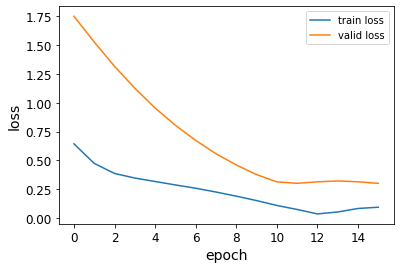

In [71]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='valid loss')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

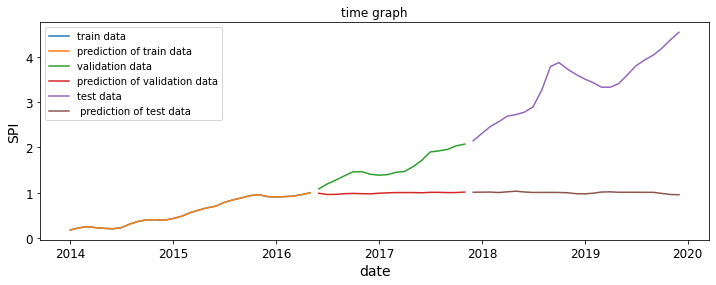

In [72]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

##  LSTM 모델 [layer=3, units=20, optimizer = 'adam', epochs=1000, batch_size=40]

In [73]:
np.random.seed(52)
tf.random.set_seed(52)

model = Sequential()
model.add(LSTM(5, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(5, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics=['mse','mae'])

model.fit(train_X, train_y, epochs=1000, batch_size=29, validation_data=(valid_X, valid_y), verbose=2)

Epoch 1/1000
1/1 - 1s - loss: 0.4264 - mse: 0.4264 - mae: 0.5857 - val_loss: 2.5317 - val_mse: 2.5317 - val_mae: 1.5646
Epoch 2/1000
1/1 - 0s - loss: 0.4224 - mse: 0.4224 - mae: 0.5822 - val_loss: 2.5209 - val_mse: 2.5209 - val_mae: 1.5612
Epoch 3/1000
1/1 - 0s - loss: 0.4186 - mse: 0.4186 - mae: 0.5789 - val_loss: 2.5102 - val_mse: 2.5102 - val_mae: 1.5577
Epoch 4/1000
1/1 - 0s - loss: 0.4149 - mse: 0.4149 - mae: 0.5757 - val_loss: 2.4996 - val_mse: 2.4996 - val_mae: 1.5543
Epoch 5/1000
1/1 - 0s - loss: 0.4111 - mse: 0.4111 - mae: 0.5724 - val_loss: 2.4889 - val_mse: 2.4889 - val_mae: 1.5508
Epoch 6/1000
1/1 - 0s - loss: 0.4072 - mse: 0.4072 - mae: 0.5689 - val_loss: 2.4777 - val_mse: 2.4777 - val_mae: 1.5473
Epoch 7/1000
1/1 - 0s - loss: 0.4032 - mse: 0.4032 - mae: 0.5654 - val_loss: 2.4660 - val_mse: 2.4660 - val_mae: 1.5435
Epoch 8/1000
1/1 - 0s - loss: 0.3990 - mse: 0.3990 - mae: 0.5617 - val_loss: 2.4538 - val_mse: 2.4538 - val_mae: 1.5395
Epoch 9/1000
1/1 - 0s - loss: 0.3948 - m

Epoch 69/1000
1/1 - 0s - loss: 0.1823 - mse: 0.1823 - mae: 0.3377 - val_loss: 1.7495 - val_mse: 1.7495 - val_mae: 1.2907
Epoch 70/1000
1/1 - 0s - loss: 0.1794 - mse: 0.1794 - mae: 0.3354 - val_loss: 1.7376 - val_mse: 1.7376 - val_mae: 1.2861
Epoch 71/1000
1/1 - 0s - loss: 0.1766 - mse: 0.1766 - mae: 0.3330 - val_loss: 1.7257 - val_mse: 1.7257 - val_mae: 1.2814
Epoch 72/1000
1/1 - 0s - loss: 0.1738 - mse: 0.1738 - mae: 0.3305 - val_loss: 1.7137 - val_mse: 1.7137 - val_mae: 1.2768
Epoch 73/1000
1/1 - 0s - loss: 0.1710 - mse: 0.1710 - mae: 0.3281 - val_loss: 1.7017 - val_mse: 1.7017 - val_mae: 1.2720
Epoch 74/1000
1/1 - 0s - loss: 0.1682 - mse: 0.1682 - mae: 0.3257 - val_loss: 1.6896 - val_mse: 1.6896 - val_mae: 1.2673
Epoch 75/1000
1/1 - 0s - loss: 0.1655 - mse: 0.1655 - mae: 0.3232 - val_loss: 1.6776 - val_mse: 1.6776 - val_mae: 1.2625
Epoch 76/1000
1/1 - 0s - loss: 0.1628 - mse: 0.1628 - mae: 0.3208 - val_loss: 1.6655 - val_mse: 1.6655 - val_mae: 1.2577
Epoch 77/1000
1/1 - 0s - loss: 0

Epoch 137/1000
1/1 - 0s - loss: 0.0822 - mse: 0.0822 - mae: 0.2625 - val_loss: 1.0723 - val_mse: 1.0723 - val_mae: 0.9944
Epoch 138/1000
1/1 - 0s - loss: 0.0813 - mse: 0.0813 - mae: 0.2612 - val_loss: 1.0682 - val_mse: 1.0682 - val_mae: 0.9923
Epoch 139/1000
1/1 - 0s - loss: 0.0798 - mse: 0.0798 - mae: 0.2590 - val_loss: 1.0641 - val_mse: 1.0641 - val_mae: 0.9902
Epoch 140/1000
1/1 - 0s - loss: 0.0776 - mse: 0.0776 - mae: 0.2555 - val_loss: 1.0602 - val_mse: 1.0602 - val_mae: 0.9882
Epoch 141/1000
1/1 - 0s - loss: 0.0745 - mse: 0.0745 - mae: 0.2501 - val_loss: 1.0563 - val_mse: 1.0563 - val_mae: 0.9863
Epoch 142/1000
1/1 - 0s - loss: 0.0707 - mse: 0.0707 - mae: 0.2428 - val_loss: 1.0523 - val_mse: 1.0523 - val_mae: 0.9843
Epoch 143/1000
1/1 - 0s - loss: 0.0669 - mse: 0.0669 - mae: 0.2343 - val_loss: 1.0483 - val_mse: 1.0483 - val_mae: 0.9823
Epoch 144/1000
1/1 - 0s - loss: 0.0639 - mse: 0.0639 - mae: 0.2270 - val_loss: 1.0444 - val_mse: 1.0444 - val_mae: 0.9804
Epoch 145/1000
1/1 - 0s 

Epoch 205/1000
1/1 - 0s - loss: 0.0025 - mse: 0.0025 - mae: 0.0392 - val_loss: 0.5585 - val_mse: 0.5585 - val_mae: 0.6892
Epoch 206/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - mae: 0.0379 - val_loss: 0.5536 - val_mse: 0.5536 - val_mae: 0.6856
Epoch 207/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0368 - val_loss: 0.5490 - val_mse: 0.5490 - val_mae: 0.6823
Epoch 208/1000
1/1 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0358 - val_loss: 0.5445 - val_mse: 0.5445 - val_mae: 0.6790
Epoch 209/1000
1/1 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0348 - val_loss: 0.5403 - val_mse: 0.5403 - val_mae: 0.6759
Epoch 210/1000
1/1 - 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0338 - val_loss: 0.5362 - val_mse: 0.5362 - val_mae: 0.6728
Epoch 211/1000
1/1 - 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0330 - val_loss: 0.5322 - val_mse: 0.5322 - val_mae: 0.6699
Epoch 212/1000
1/1 - 0s - loss: 0.0016 - mse: 0.0016 - mae: 0.0323 - val_loss: 0.5284 - val_mse: 0.5284 - val_mae: 0.6670
Epoch 213/1000
1/1 - 0s 

Epoch 270/1000
1/1 - 0s - loss: 5.3727e-04 - mse: 5.3727e-04 - mae: 0.0198 - val_loss: 0.4613 - val_mse: 0.4613 - val_mae: 0.6147
Epoch 271/1000
1/1 - 0s - loss: 5.3419e-04 - mse: 5.3419e-04 - mae: 0.0197 - val_loss: 0.4613 - val_mse: 0.4613 - val_mae: 0.6147
Epoch 272/1000
1/1 - 0s - loss: 5.3114e-04 - mse: 5.3114e-04 - mae: 0.0196 - val_loss: 0.4613 - val_mse: 0.4613 - val_mae: 0.6147
Epoch 273/1000
1/1 - 0s - loss: 5.2811e-04 - mse: 5.2811e-04 - mae: 0.0196 - val_loss: 0.4613 - val_mse: 0.4613 - val_mae: 0.6147
Epoch 274/1000
1/1 - 0s - loss: 5.2510e-04 - mse: 5.2510e-04 - mae: 0.0195 - val_loss: 0.4612 - val_mse: 0.4612 - val_mae: 0.6147
Epoch 275/1000
1/1 - 0s - loss: 5.2213e-04 - mse: 5.2213e-04 - mae: 0.0194 - val_loss: 0.4612 - val_mse: 0.4612 - val_mae: 0.6147
Epoch 276/1000
1/1 - 0s - loss: 5.1921e-04 - mse: 5.1921e-04 - mae: 0.0193 - val_loss: 0.4612 - val_mse: 0.4612 - val_mae: 0.6147
Epoch 277/1000
1/1 - 0s - loss: 5.1634e-04 - mse: 5.1634e-04 - mae: 0.0193 - val_loss: 0.4

Epoch 334/1000
1/1 - 0s - loss: 3.9876e-04 - mse: 3.9876e-04 - mae: 0.0164 - val_loss: 0.4613 - val_mse: 0.4613 - val_mae: 0.6147
Epoch 335/1000
1/1 - 0s - loss: 3.9725e-04 - mse: 3.9725e-04 - mae: 0.0163 - val_loss: 0.4612 - val_mse: 0.4612 - val_mae: 0.6147
Epoch 336/1000
1/1 - 0s - loss: 3.9575e-04 - mse: 3.9575e-04 - mae: 0.0163 - val_loss: 0.4612 - val_mse: 0.4612 - val_mae: 0.6147
Epoch 337/1000
1/1 - 0s - loss: 3.9426e-04 - mse: 3.9426e-04 - mae: 0.0162 - val_loss: 0.4612 - val_mse: 0.4612 - val_mae: 0.6147
Epoch 338/1000
1/1 - 0s - loss: 3.9279e-04 - mse: 3.9279e-04 - mae: 0.0162 - val_loss: 0.4612 - val_mse: 0.4612 - val_mae: 0.6147
Epoch 339/1000
1/1 - 0s - loss: 3.9133e-04 - mse: 3.9133e-04 - mae: 0.0161 - val_loss: 0.4612 - val_mse: 0.4612 - val_mae: 0.6147
Epoch 340/1000
1/1 - 0s - loss: 3.8989e-04 - mse: 3.8989e-04 - mae: 0.0161 - val_loss: 0.4612 - val_mse: 0.4612 - val_mae: 0.6146
Epoch 341/1000
1/1 - 0s - loss: 3.8846e-04 - mse: 3.8846e-04 - mae: 0.0161 - val_loss: 0.4

Epoch 398/1000
1/1 - 0s - loss: 3.2499e-04 - mse: 3.2499e-04 - mae: 0.0140 - val_loss: 0.4610 - val_mse: 0.4610 - val_mae: 0.6145
Epoch 399/1000
1/1 - 0s - loss: 3.2414e-04 - mse: 3.2414e-04 - mae: 0.0140 - val_loss: 0.4610 - val_mse: 0.4610 - val_mae: 0.6145
Epoch 400/1000
1/1 - 0s - loss: 3.2329e-04 - mse: 3.2329e-04 - mae: 0.0139 - val_loss: 0.4610 - val_mse: 0.4610 - val_mae: 0.6145
Epoch 401/1000
1/1 - 0s - loss: 3.2245e-04 - mse: 3.2245e-04 - mae: 0.0139 - val_loss: 0.4610 - val_mse: 0.4610 - val_mae: 0.6145
Epoch 402/1000
1/1 - 0s - loss: 3.2162e-04 - mse: 3.2162e-04 - mae: 0.0139 - val_loss: 0.4610 - val_mse: 0.4610 - val_mae: 0.6145
Epoch 403/1000
1/1 - 0s - loss: 3.2079e-04 - mse: 3.2079e-04 - mae: 0.0138 - val_loss: 0.4610 - val_mse: 0.4610 - val_mae: 0.6145
Epoch 404/1000
1/1 - 0s - loss: 3.1997e-04 - mse: 3.1997e-04 - mae: 0.0138 - val_loss: 0.4610 - val_mse: 0.4610 - val_mae: 0.6145
Epoch 405/1000
1/1 - 0s - loss: 3.1916e-04 - mse: 3.1916e-04 - mae: 0.0138 - val_loss: 0.4

Epoch 462/1000
1/1 - 0s - loss: 2.8230e-04 - mse: 2.8230e-04 - mae: 0.0122 - val_loss: 0.4609 - val_mse: 0.4609 - val_mae: 0.6145
Epoch 463/1000
1/1 - 0s - loss: 2.8179e-04 - mse: 2.8179e-04 - mae: 0.0122 - val_loss: 0.4609 - val_mse: 0.4609 - val_mae: 0.6145
Epoch 464/1000
1/1 - 0s - loss: 2.8128e-04 - mse: 2.8128e-04 - mae: 0.0122 - val_loss: 0.4609 - val_mse: 0.4609 - val_mae: 0.6145
Epoch 465/1000
1/1 - 0s - loss: 2.8078e-04 - mse: 2.8078e-04 - mae: 0.0122 - val_loss: 0.4609 - val_mse: 0.4609 - val_mae: 0.6145
Epoch 466/1000
1/1 - 0s - loss: 2.8028e-04 - mse: 2.8028e-04 - mae: 0.0122 - val_loss: 0.4609 - val_mse: 0.4609 - val_mae: 0.6145
Epoch 467/1000
1/1 - 0s - loss: 2.7979e-04 - mse: 2.7979e-04 - mae: 0.0121 - val_loss: 0.4609 - val_mse: 0.4609 - val_mae: 0.6145
Epoch 468/1000
1/1 - 0s - loss: 2.7930e-04 - mse: 2.7930e-04 - mae: 0.0121 - val_loss: 0.4609 - val_mse: 0.4609 - val_mae: 0.6145
Epoch 469/1000
1/1 - 0s - loss: 2.7881e-04 - mse: 2.7881e-04 - mae: 0.0121 - val_loss: 0.4

1/1 - 0s - loss: 2.5630e-04 - mse: 2.5630e-04 - mae: 0.0112 - val_loss: 0.4607 - val_mse: 0.4607 - val_mae: 0.6143
Epoch 526/1000
1/1 - 0s - loss: 2.5596e-04 - mse: 2.5596e-04 - mae: 0.0111 - val_loss: 0.4607 - val_mse: 0.4607 - val_mae: 0.6143
Epoch 527/1000
1/1 - 0s - loss: 2.5563e-04 - mse: 2.5563e-04 - mae: 0.0111 - val_loss: 0.4607 - val_mse: 0.4607 - val_mae: 0.6143
Epoch 528/1000
1/1 - 0s - loss: 2.5530e-04 - mse: 2.5530e-04 - mae: 0.0111 - val_loss: 0.4607 - val_mse: 0.4607 - val_mae: 0.6143
Epoch 529/1000
1/1 - 0s - loss: 2.5497e-04 - mse: 2.5497e-04 - mae: 0.0111 - val_loss: 0.4607 - val_mse: 0.4607 - val_mae: 0.6143
Epoch 530/1000
1/1 - 0s - loss: 2.5465e-04 - mse: 2.5465e-04 - mae: 0.0111 - val_loss: 0.4606 - val_mse: 0.4606 - val_mae: 0.6142
Epoch 531/1000
1/1 - 0s - loss: 2.5432e-04 - mse: 2.5432e-04 - mae: 0.0111 - val_loss: 0.4606 - val_mse: 0.4606 - val_mae: 0.6142
Epoch 532/1000
1/1 - 0s - loss: 2.5400e-04 - mse: 2.5400e-04 - mae: 0.0111 - val_loss: 0.4606 - val_mse: 

Epoch 589/1000
1/1 - 0s - loss: 2.3771e-04 - mse: 2.3771e-04 - mae: 0.0102 - val_loss: 0.4599 - val_mse: 0.4599 - val_mae: 0.6137
Epoch 590/1000
1/1 - 0s - loss: 2.3745e-04 - mse: 2.3745e-04 - mae: 0.0102 - val_loss: 0.4599 - val_mse: 0.4599 - val_mae: 0.6137
Epoch 591/1000
1/1 - 0s - loss: 2.3719e-04 - mse: 2.3719e-04 - mae: 0.0102 - val_loss: 0.4599 - val_mse: 0.4599 - val_mae: 0.6137
Epoch 592/1000
1/1 - 0s - loss: 2.3693e-04 - mse: 2.3693e-04 - mae: 0.0102 - val_loss: 0.4599 - val_mse: 0.4599 - val_mae: 0.6136
Epoch 593/1000
1/1 - 0s - loss: 2.3667e-04 - mse: 2.3667e-04 - mae: 0.0102 - val_loss: 0.4598 - val_mse: 0.4598 - val_mae: 0.6136
Epoch 594/1000
1/1 - 0s - loss: 2.3641e-04 - mse: 2.3641e-04 - mae: 0.0102 - val_loss: 0.4598 - val_mse: 0.4598 - val_mae: 0.6136
Epoch 595/1000
1/1 - 0s - loss: 2.3615e-04 - mse: 2.3615e-04 - mae: 0.0102 - val_loss: 0.4598 - val_mse: 0.4598 - val_mae: 0.6136
Epoch 596/1000
1/1 - 0s - loss: 2.3590e-04 - mse: 2.3590e-04 - mae: 0.0101 - val_loss: 0.4

1/1 - 0s - loss: 2.2124e-04 - mse: 2.2124e-04 - mae: 0.0095 - val_loss: 0.4583 - val_mse: 0.4583 - val_mae: 0.6124
Epoch 653/1000
1/1 - 0s - loss: 2.2096e-04 - mse: 2.2096e-04 - mae: 0.0095 - val_loss: 0.4583 - val_mse: 0.4583 - val_mae: 0.6124
Epoch 654/1000
1/1 - 0s - loss: 2.2068e-04 - mse: 2.2068e-04 - mae: 0.0095 - val_loss: 0.4582 - val_mse: 0.4582 - val_mae: 0.6124
Epoch 655/1000
1/1 - 0s - loss: 2.2040e-04 - mse: 2.2040e-04 - mae: 0.0095 - val_loss: 0.4582 - val_mse: 0.4582 - val_mae: 0.6123
Epoch 656/1000
1/1 - 0s - loss: 2.2012e-04 - mse: 2.2012e-04 - mae: 0.0094 - val_loss: 0.4582 - val_mse: 0.4582 - val_mae: 0.6123
Epoch 657/1000
1/1 - 0s - loss: 2.1984e-04 - mse: 2.1984e-04 - mae: 0.0094 - val_loss: 0.4581 - val_mse: 0.4581 - val_mae: 0.6123
Epoch 658/1000
1/1 - 0s - loss: 2.1956e-04 - mse: 2.1956e-04 - mae: 0.0094 - val_loss: 0.4581 - val_mse: 0.4581 - val_mae: 0.6123
Epoch 659/1000
1/1 - 0s - loss: 2.1927e-04 - mse: 2.1927e-04 - mae: 0.0094 - val_loss: 0.4581 - val_mse: 

Epoch 716/1000
1/1 - 0s - loss: 1.9944e-04 - mse: 1.9944e-04 - mae: 0.0088 - val_loss: 0.4550 - val_mse: 0.4550 - val_mae: 0.6098
Epoch 717/1000
1/1 - 0s - loss: 1.9900e-04 - mse: 1.9900e-04 - mae: 0.0087 - val_loss: 0.4549 - val_mse: 0.4549 - val_mae: 0.6097
Epoch 718/1000
1/1 - 0s - loss: 1.9855e-04 - mse: 1.9855e-04 - mae: 0.0087 - val_loss: 0.4548 - val_mse: 0.4548 - val_mae: 0.6097
Epoch 719/1000
1/1 - 0s - loss: 1.9810e-04 - mse: 1.9810e-04 - mae: 0.0087 - val_loss: 0.4547 - val_mse: 0.4547 - val_mae: 0.6096
Epoch 720/1000
1/1 - 0s - loss: 1.9764e-04 - mse: 1.9764e-04 - mae: 0.0087 - val_loss: 0.4547 - val_mse: 0.4547 - val_mae: 0.6096
Epoch 721/1000
1/1 - 0s - loss: 1.9718e-04 - mse: 1.9718e-04 - mae: 0.0087 - val_loss: 0.4546 - val_mse: 0.4546 - val_mae: 0.6095
Epoch 722/1000
1/1 - 0s - loss: 1.9671e-04 - mse: 1.9671e-04 - mae: 0.0087 - val_loss: 0.4545 - val_mse: 0.4545 - val_mae: 0.6094
Epoch 723/1000
1/1 - 0s - loss: 1.9624e-04 - mse: 1.9624e-04 - mae: 0.0087 - val_loss: 0.4

Epoch 780/1000
1/1 - 0s - loss: 1.5677e-04 - mse: 1.5677e-04 - mae: 0.0075 - val_loss: 0.4472 - val_mse: 0.4472 - val_mae: 0.6037
Epoch 781/1000
1/1 - 0s - loss: 1.5579e-04 - mse: 1.5579e-04 - mae: 0.0075 - val_loss: 0.4470 - val_mse: 0.4470 - val_mae: 0.6036
Epoch 782/1000
1/1 - 0s - loss: 1.5480e-04 - mse: 1.5480e-04 - mae: 0.0074 - val_loss: 0.4469 - val_mse: 0.4469 - val_mae: 0.6034
Epoch 783/1000
1/1 - 0s - loss: 1.5379e-04 - mse: 1.5379e-04 - mae: 0.0074 - val_loss: 0.4467 - val_mse: 0.4467 - val_mae: 0.6033
Epoch 784/1000
1/1 - 0s - loss: 1.5277e-04 - mse: 1.5277e-04 - mae: 0.0074 - val_loss: 0.4465 - val_mse: 0.4465 - val_mae: 0.6031
Epoch 785/1000
1/1 - 0s - loss: 1.5174e-04 - mse: 1.5174e-04 - mae: 0.0073 - val_loss: 0.4463 - val_mse: 0.4463 - val_mae: 0.6029
Epoch 786/1000
1/1 - 0s - loss: 1.5071e-04 - mse: 1.5071e-04 - mae: 0.0073 - val_loss: 0.4461 - val_mse: 0.4461 - val_mae: 0.6028
Epoch 787/1000
1/1 - 0s - loss: 1.4965e-04 - mse: 1.4965e-04 - mae: 0.0073 - val_loss: 0.4

Epoch 844/1000
1/1 - 0s - loss: 8.5394e-05 - mse: 8.5394e-05 - mae: 0.0051 - val_loss: 0.4302 - val_mse: 0.4302 - val_mae: 0.5900
Epoch 845/1000
1/1 - 0s - loss: 8.4497e-05 - mse: 8.4497e-05 - mae: 0.0051 - val_loss: 0.4299 - val_mse: 0.4299 - val_mae: 0.5898
Epoch 846/1000
1/1 - 0s - loss: 8.3616e-05 - mse: 8.3616e-05 - mae: 0.0050 - val_loss: 0.4295 - val_mse: 0.4295 - val_mae: 0.5895
Epoch 847/1000
1/1 - 0s - loss: 8.2750e-05 - mse: 8.2750e-05 - mae: 0.0050 - val_loss: 0.4292 - val_mse: 0.4292 - val_mae: 0.5893
Epoch 848/1000
1/1 - 0s - loss: 8.1898e-05 - mse: 8.1898e-05 - mae: 0.0050 - val_loss: 0.4289 - val_mse: 0.4289 - val_mae: 0.5890
Epoch 849/1000
1/1 - 0s - loss: 8.1061e-05 - mse: 8.1061e-05 - mae: 0.0050 - val_loss: 0.4286 - val_mse: 0.4286 - val_mae: 0.5888
Epoch 850/1000
1/1 - 0s - loss: 8.0240e-05 - mse: 8.0240e-05 - mae: 0.0050 - val_loss: 0.4284 - val_mse: 0.4284 - val_mae: 0.5885
Epoch 851/1000
1/1 - 0s - loss: 7.9432e-05 - mse: 7.9432e-05 - mae: 0.0050 - val_loss: 0.4

Epoch 908/1000
1/1 - 0s - loss: 5.0404e-05 - mse: 5.0404e-05 - mae: 0.0046 - val_loss: 0.4155 - val_mse: 0.4155 - val_mae: 0.5779
Epoch 909/1000
1/1 - 0s - loss: 5.0071e-05 - mse: 5.0071e-05 - mae: 0.0046 - val_loss: 0.4153 - val_mse: 0.4153 - val_mae: 0.5777
Epoch 910/1000
1/1 - 0s - loss: 4.9741e-05 - mse: 4.9741e-05 - mae: 0.0045 - val_loss: 0.4152 - val_mse: 0.4152 - val_mae: 0.5776
Epoch 911/1000
1/1 - 0s - loss: 4.9414e-05 - mse: 4.9414e-05 - mae: 0.0045 - val_loss: 0.4150 - val_mse: 0.4150 - val_mae: 0.5775
Epoch 912/1000
1/1 - 0s - loss: 4.9091e-05 - mse: 4.9091e-05 - mae: 0.0045 - val_loss: 0.4149 - val_mse: 0.4149 - val_mae: 0.5774
Epoch 913/1000
1/1 - 0s - loss: 4.8771e-05 - mse: 4.8771e-05 - mae: 0.0045 - val_loss: 0.4147 - val_mse: 0.4147 - val_mae: 0.5772
Epoch 914/1000
1/1 - 0s - loss: 4.8453e-05 - mse: 4.8453e-05 - mae: 0.0045 - val_loss: 0.4146 - val_mse: 0.4146 - val_mae: 0.5771
Epoch 915/1000
1/1 - 0s - loss: 4.8138e-05 - mse: 4.8138e-05 - mae: 0.0045 - val_loss: 0.4

Epoch 972/1000
1/1 - 0s - loss: 3.3594e-05 - mse: 3.3594e-05 - mae: 0.0039 - val_loss: 0.4074 - val_mse: 0.4074 - val_mae: 0.5710
Epoch 973/1000
1/1 - 0s - loss: 3.3384e-05 - mse: 3.3384e-05 - mae: 0.0039 - val_loss: 0.4073 - val_mse: 0.4073 - val_mae: 0.5709
Epoch 974/1000
1/1 - 0s - loss: 3.3174e-05 - mse: 3.3174e-05 - mae: 0.0039 - val_loss: 0.4072 - val_mse: 0.4072 - val_mae: 0.5709
Epoch 975/1000
1/1 - 0s - loss: 3.2966e-05 - mse: 3.2966e-05 - mae: 0.0039 - val_loss: 0.4071 - val_mse: 0.4071 - val_mae: 0.5708
Epoch 976/1000
1/1 - 0s - loss: 3.2759e-05 - mse: 3.2759e-05 - mae: 0.0039 - val_loss: 0.4070 - val_mse: 0.4070 - val_mae: 0.5707
Epoch 977/1000
1/1 - 0s - loss: 3.2553e-05 - mse: 3.2553e-05 - mae: 0.0038 - val_loss: 0.4069 - val_mse: 0.4069 - val_mae: 0.5706
Epoch 978/1000
1/1 - 0s - loss: 3.2348e-05 - mse: 3.2348e-05 - mae: 0.0038 - val_loss: 0.4068 - val_mse: 0.4068 - val_mae: 0.5705
Epoch 979/1000
1/1 - 0s - loss: 3.2144e-05 - mse: 3.2144e-05 - mae: 0.0038 - val_loss: 0.4

In [74]:
y_pred_train = model.predict(train_X)
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)
#-----------------------------------------
df_y_pred_train = pd.DataFrame(y_pred_train)
df_y_train = pd.DataFrame(train_y)

df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)
#-------------------------------------------
df_y_pred_train.columns=['SPI']
df_y_train.columns=['SPI']

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']

# df_time_valid.shape

df_y_pred_train = df_y_pred_train.set_index(df_time_train)
df_y_train = df_y_train.set_index(df_time_train)

df_y_pred= df_y_pred.set_index(df_time_valid)
df_y_valid = df_y_valid.set_index(df_time_valid)

df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
df_y_test = df_y_test.set_index(df_time_test)

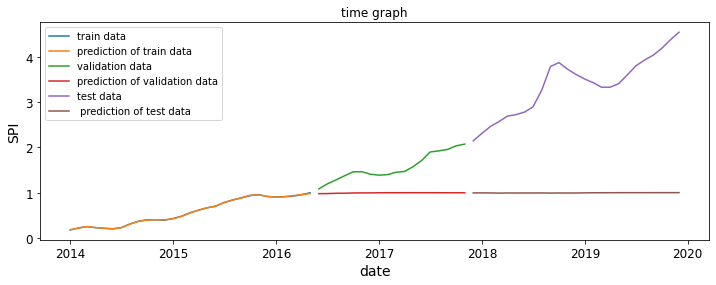

In [75]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_train, label = "train data")
axes1.plot(df_y_pred_train, label = "prediction of train data")
axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")
axes1.plot(df_y_test, label = "test data")
axes1.plot(df_y_pred_test, label = " prediction of test data")
axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()